# Clustering initialization

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
# This will automatically reload modules before executing code that depends on them.

from copy import deepcopy

# 3rd party imports
import numpy as np
np.set_printoptions(linewidth=1000)
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from pprint import pprint

# local imports
from modules import jacobian
from modules.data_fixed import Data
from cluster_modules import cluster, data_utils, reg_utils

## Create sample datasets

Plotted 30 point correspondences
Set 1 - X range: [50.0, 150.0], Y range: [50.3, 149.7]
Set 2 - X range: [82.8, 217.2], Y range: [51.8, 148.2]
Correspondence distances - Mean: 58.73, Std: 14.59, Max: 83.64


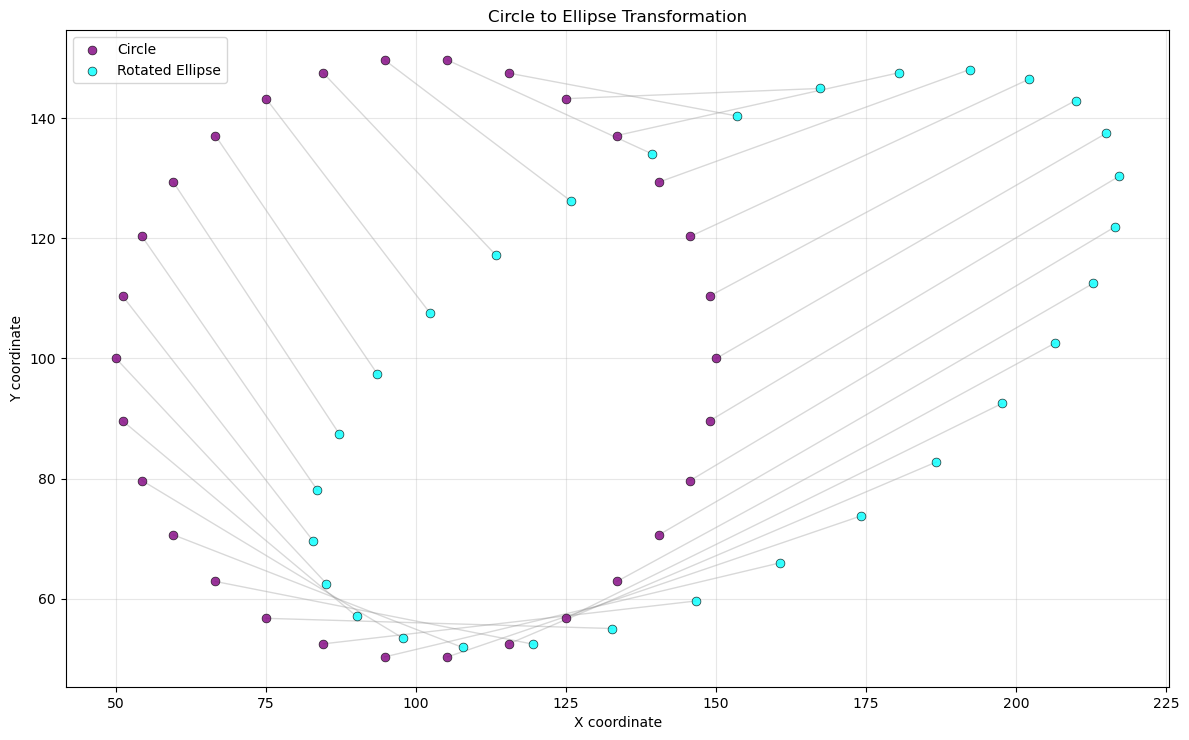

In [2]:
circle_points, ellipse_points = data_utils.circle_to_ellipse_correspondences()

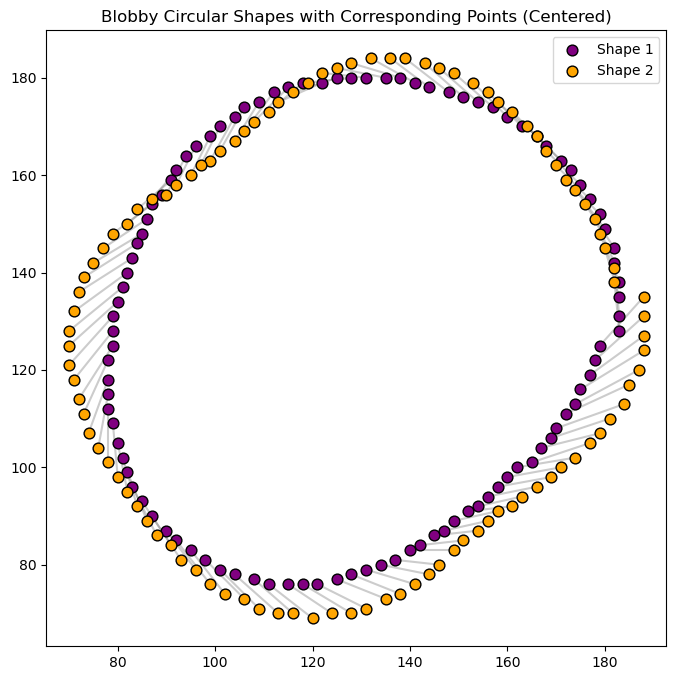

In [3]:
blob1, blob2 = data_utils.create_blobby_circular_shapes(n_points=100, plot=True, noise_scale=6)

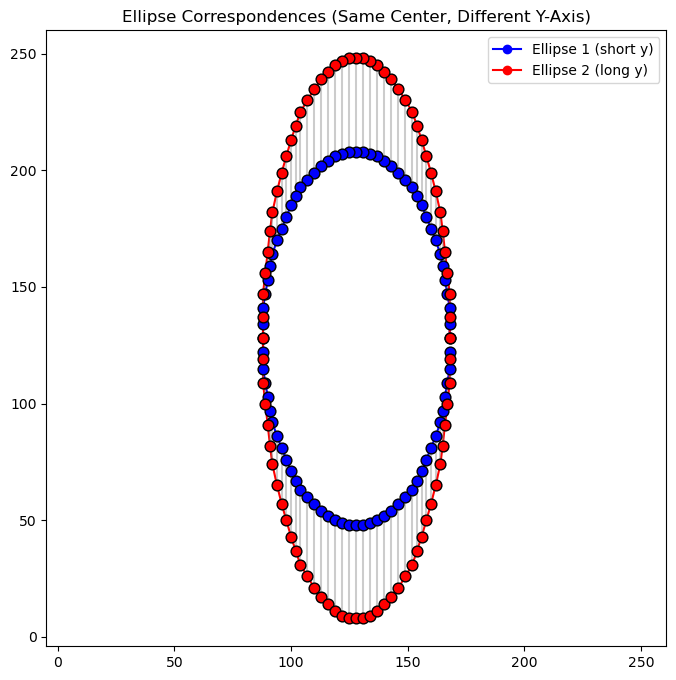

In [4]:
ellipse1, ellipse2 = data_utils.create_ellipse_correspondences(n_points=80, plot=True)

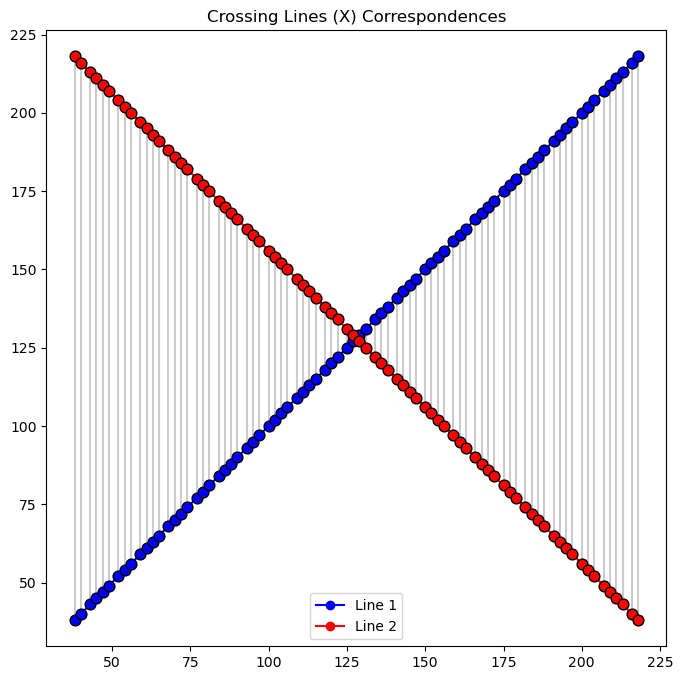

In [5]:
line1, line2 = data_utils.create_crossing_lines_correspondences(n_points=80, plot=True)

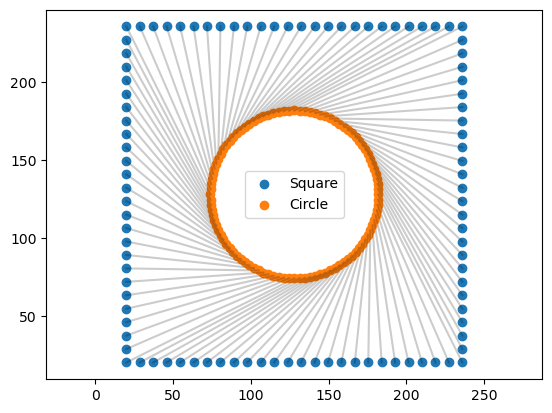

In [6]:
def square_to_circle_correspondences(n_points=100, square_size=1.0, circle_radius=1.0, resolution=(256, 256), padding=20):
    """
    Generates n_points correspondences from a square to a circle,
    mapped to a given image resolution with padding from the edges.
    Returns:
        square_points: (n_points, 2) array of (x, y) in image coordinates
        circle_points: (n_points, 2) array of (x, y) in image coordinates
    """
    # Square points: uniformly sample points along the square perimeter in CCW order starting from bottom left
    per_side = n_points // 4
    remainder = n_points % 4
    sides = [per_side] * 4
    for i in range(remainder):
        sides[i] += 1

    # Bottom (left to right)
    x0 = np.linspace(-square_size, square_size, sides[0], endpoint=False)
    y0 = np.full_like(x0, -square_size)
    # Right (bottom to top)
    y1 = np.linspace(-square_size, square_size, sides[1], endpoint=False)
    x1 = np.full_like(y1, square_size)
    # Top (right to left)
    x2 = np.linspace(square_size, -square_size, sides[2], endpoint=False)
    y2 = np.full_like(x2, square_size)
    # Left (top to bottom)
    y3 = np.linspace(square_size, -square_size, sides[3], endpoint=False)
    x3 = np.full_like(y3, -square_size)

    square_points = np.concatenate([
        np.stack([x0, y0], axis=1),
        np.stack([x1, y1], axis=1),
        np.stack([x2, y2], axis=1),
        np.stack([x3, y3], axis=1)
    ], axis=0)

    # Map each square point to a circle point by angle, starting at -pi/2 (bottom)
    angles = np.linspace(-np.pi/2, 3*np.pi/2, n_points, endpoint=False)
    circle_points = np.stack([
        circle_radius * np.cos(angles),
        circle_radius * np.sin(angles)
    ], axis=1)

    # Center both shapes in the image
    img_center = np.array(resolution) / 2

    def to_image_coords(points, obj_size):
        # Scale so that the largest shape fits within the padded area
        scale = (np.array(resolution) - 2 * padding) / (2 * max(square_size, circle_radius))
        img_points = points * scale + img_center
        return img_points

    square_img_points = to_image_coords(square_points, square_size)
    circle_img_points = to_image_coords(circle_points, circle_radius)

    return square_img_points, circle_img_points

# Usage example
square_pts, circle_pts = square_to_circle_correspondences(n_points=100, circle_radius=0.5)
plt.scatter(square_pts[:,0], square_pts[:,1], label='Square')
plt.scatter(circle_pts[:,0], circle_pts[:,1], label='Circle')
for i in range(len(square_pts)):
    plt.plot([square_pts[i,0], circle_pts[i,0]], [square_pts[i,1], circle_pts[i,1]], 'k-', alpha=0.2)
plt.legend()
plt.axis('equal')
plt.show()

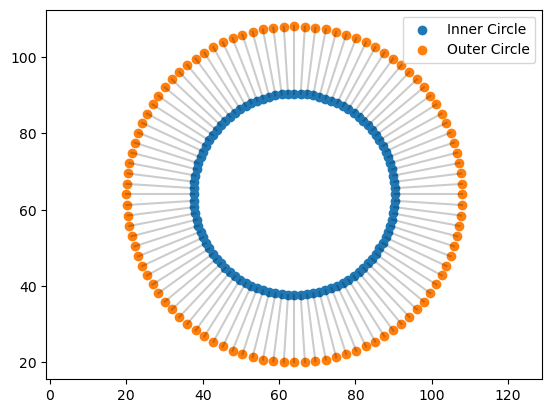

In [7]:
def circle_to_circle_correspondences(n_points=100, inner_radius=0.5, outer_radius=1.0, resolution=(256, 256), padding=20):
    """
    Generates n_points correspondences from an inner circle to an outer circle,
    mapped to a given image resolution with padding from the edges.
    Returns:
        inner_points: (n_points, 2) array of (x, y) in image coordinates
        outer_points: (n_points, 2) array of (x, y) in image coordinates
    """
    # Sample points along the perimeter, CCW starting from bottom
    angles = np.linspace(-np.pi/2, 3*np.pi/2, n_points, endpoint=False)
    inner_points = np.stack([
        inner_radius * np.cos(angles),
        inner_radius * np.sin(angles)
    ], axis=1)
    outer_points = np.stack([
        outer_radius * np.cos(angles),
        outer_radius * np.sin(angles)
    ], axis=1)

    # Center both shapes in the image
    img_center = np.array(resolution) / 2

    def to_image_coords(points, obj_size):
        # Scale so that the largest shape fits within the padded area
        scale = (np.array(resolution) - 2 * padding) / (2 * outer_radius)
        img_points = points * scale + img_center
        return img_points

    inner_img_points = to_image_coords(inner_points, inner_radius)
    outer_img_points = to_image_coords(outer_points, outer_radius)

    return inner_img_points, outer_img_points

# Usage example
inner_pts, outer_pts = circle_to_circle_correspondences(n_points=100, resolution=(128, 128), inner_radius=0.15, outer_radius=0.25)
plt.scatter(inner_pts[:,0], inner_pts[:,1], label='Inner Circle')
plt.scatter(outer_pts[:,0], outer_pts[:,1], label='Outer Circle')
for i in range(len(inner_pts)):
    plt.plot([inner_pts[i,0], outer_pts[i,0]], [inner_pts[i,1], outer_pts[i,1]], 'k-', alpha=0.2)
plt.legend()
plt.axis('equal')
plt.show()

# Correspondence density comparison

## Full double-helix

In [8]:
RUN_EXPERIMENT = False

if RUN_EXPERIMENT:
    # Create a specific double helix for correspondence analysis
    print("\n=== Creating Double Helix for Point Correspondence ===")

    resolution = (256, 256)  # Example resolution for the data
    points_to_skip = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Skip every nth point for better visualization

    #####################################################################################################

    for num_points_skip in points_to_skip:
        print(f"\n=== Resolution / {num_points_skip} ===")

        helix_wave1, helix_wave2, _ = data_utils.create_double_helix_waves(
            grid_size=256,
            num_cycles=2,
            amplitude_ratio=0.03,
            phase_offset=np.pi,  # 180 degrees for maximum separation
            padding_ratio=0.1,
            plot=False,
            horizontal=False  # Set horizontal to False for vertical helix
        )

        # Decrease point density for better visualization
        helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
        helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

        # Plot the correspondences between the two helical waves
        data_utils.plot_point_correspondences(helix_wave1, helix_wave2,
                                labels=('Moving points', 'Fixed points'),
                                colors=('red', 'blue'),
                                title=f'Double Helix Point Correspondences (resolution / {num_points_skip})',
                                show_indices=False,
                                line_alpha=0.2,  # More transparent lines to show the pattern better
                                point_size=20)

        # Swap columns to match expected format (x, y)
        helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
        helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

        # Add 0s on the first axis to format for Data class
        helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
        helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)

        # Run Laplacian
        d = Data(helix_wave1, helix_wave2, resolution)
        d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
            title=f"Double helix (point resolution / {num_points_skip})\nMin Jdet: {d.min():.2f}, Negatives: {d.count_negatives()}")

## Downwards cluster

In [9]:
if RUN_EXPERIMENT:
    # Create a specific double helix for correspondence analysis
    print("\n=== Creating Double Helix for Point Correspondence ===")

    resolution = (256, 256)  # Example resolution for the data
    points_to_skip = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Skip every nth point for better visualization

    #####################################################################################################

    for num_points_skip in points_to_skip:
        print(f"\n=== Resolution / {num_points_skip} ===")

        helix_wave1, helix_wave2, _ = data_utils.create_double_helix_waves(
            grid_size=256,
            num_cycles=2,
            amplitude_ratio=0.03,
            phase_offset=np.pi,  # 180 degrees for maximum separation
            padding_ratio=0.1,
            plot=False,
            horizontal=False  # Set horizontal to False for vertical helix
        )

        # Decrease point density for better visualization
        helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
        helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

        # Plot the correspondences between the two helical waves
        data_utils.plot_point_correspondences(helix_wave1, helix_wave2,
                                labels=('Moving points', 'Fixed points'),
                                colors=('red', 'blue'),
                                title='Double Helix Point Correspondences',
                                show_indices=False,
                                line_alpha=0.2,  # More transparent lines to show the pattern better
                                point_size=20)

        # Swap columns to match expected format (x, y)
        helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
        helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

        # Add 0s on the first axis to format for Data class
        helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
        helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)

        #print(f"Analyzing {len(original_moving_points)} point correspondences from double helix")
        cluster_indices, cluster_info = cluster.get_cluster_indices(helix_wave1, helix_wave2)

        # Run Laplacian
        d = Data(helix_wave1[cluster_indices[0]], helix_wave2[cluster_indices[0]], resolution)
        d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False)
        print(f"Minimum Jacobian determinant: {d.min():.2f}")
        print(f"Number of negative Jacobian determinants: {d.count_negatives()}")

## Upwards cluster

In [10]:
if RUN_EXPERIMENT:
    # Create a specific double helix for correspondence analysis
    print("\n=== Creating Double Helix for Point Correspondence ===")

    resolution = (256, 256)  # Example resolution for the data
    points_to_skip = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Skip every nth point for better visualization

    #####################################################################################################

    for num_points_skip in points_to_skip:
        print(f"\n=== Resolution / {num_points_skip} ===")

        helix_wave1, helix_wave2, _ = data_utils.create_double_helix_waves(
            grid_size=256,
            num_cycles=2,
            amplitude_ratio=0.03,
            phase_offset=np.pi,  # 180 degrees for maximum separation
            padding_ratio=0.1,
            plot=False,
            horizontal=False  # Set horizontal to False for vertical helix
        )

        # Decrease point density for better visualization
        helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
        helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

        # Plot the correspondences between the two helical waves
        data_utils.plot_point_correspondences(helix_wave1, helix_wave2,
                                labels=('Moving points', 'Fixed points'),
                                colors=('red', 'blue'),
                                title='Double Helix Point Correspondences',
                                show_indices=False,
                                line_alpha=0.2,  # More transparent lines to show the pattern better
                                point_size=20)

        # Swap columns to match expected format (x, y)
        helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
        helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

        # Add 0s on the first axis to format for Data class
        helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
        helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)

        #print(f"Analyzing {len(original_moving_points)} point correspondences from double helix")
        cluster_indices, cluster_info = cluster.get_cluster_indices(helix_wave1, helix_wave2)

        # Run Laplacian
        d = Data(helix_wave1[cluster_indices[1]], helix_wave2[cluster_indices[1]], resolution)
        d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False)
        print(f"Minimum Jacobian determinant: {d.min():.2f}")
        print(f"Number of negative Jacobian determinants: {d.count_negatives()}")

# Create data

## Parameters

In [11]:
resolution = (256, 256)  # Example resolution for the data
num_points_skip = 1  # Skip every 5th point for better visualization
shift_distance = 0  # Distance to shift the moving and fixed points from each other (try 100 for max distance)
cluster_method = 'y_direction'
m_data = None
f_data = None

## Full Laplacian


=== Creating Double Helix for Point Correspondence ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 206 point correspondences
Set 1 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.79, Std: 4.83, Max: 16.00


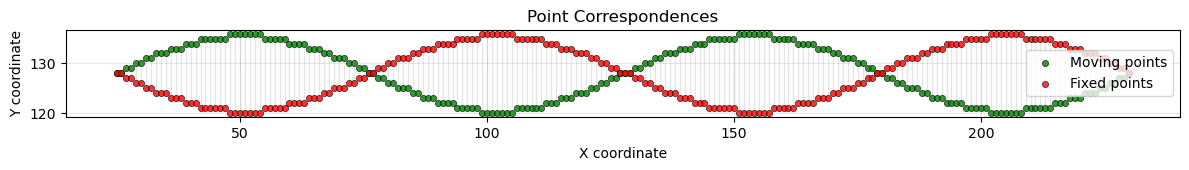

Analyzing 206 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 98 points (indices: [2, 3, 4, 5, 6]...)
  Mean displacement: Z=0.000, Y=-10.286, X=0.000
  Std displacement:  Z=0.000, Y=4.408, X=0.000
Cluster 1: 108 points (indices: [0, 1, 51, 52, 53]...)
  Mean displacement: Z=0.000, Y=9.333, X=0.000
  Std displacement:  Z=0.000, Y=5.150, X=0.000
ERROR: Error getting cluster indices. Ensure the points are in the correct format and the correct method is used (y_direction or x_direction). Using half of the points as down_indices and the other half as up_indices.


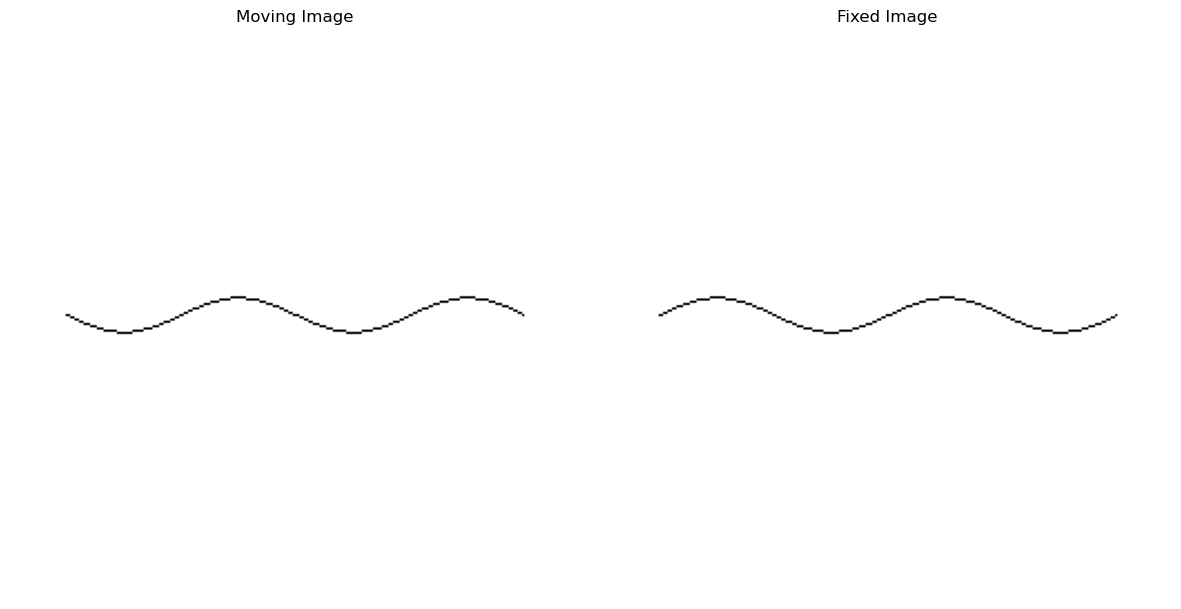

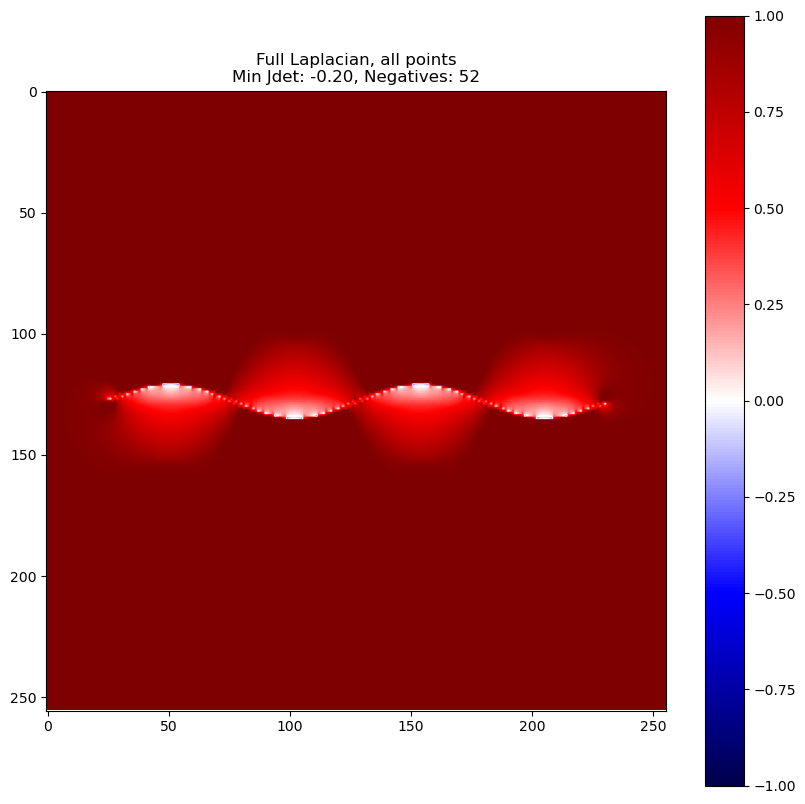

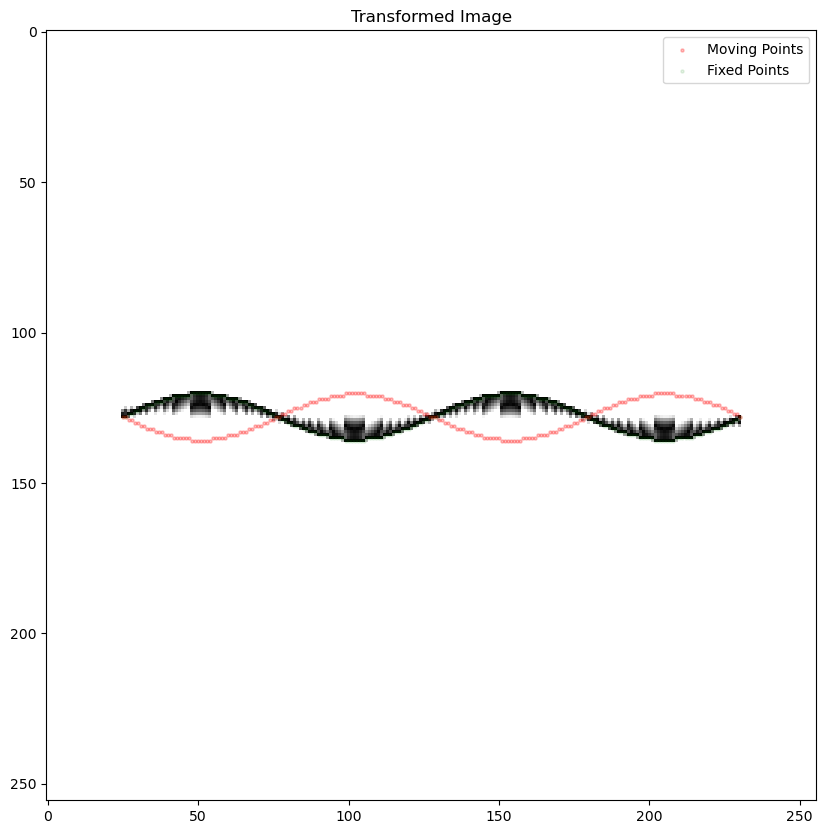

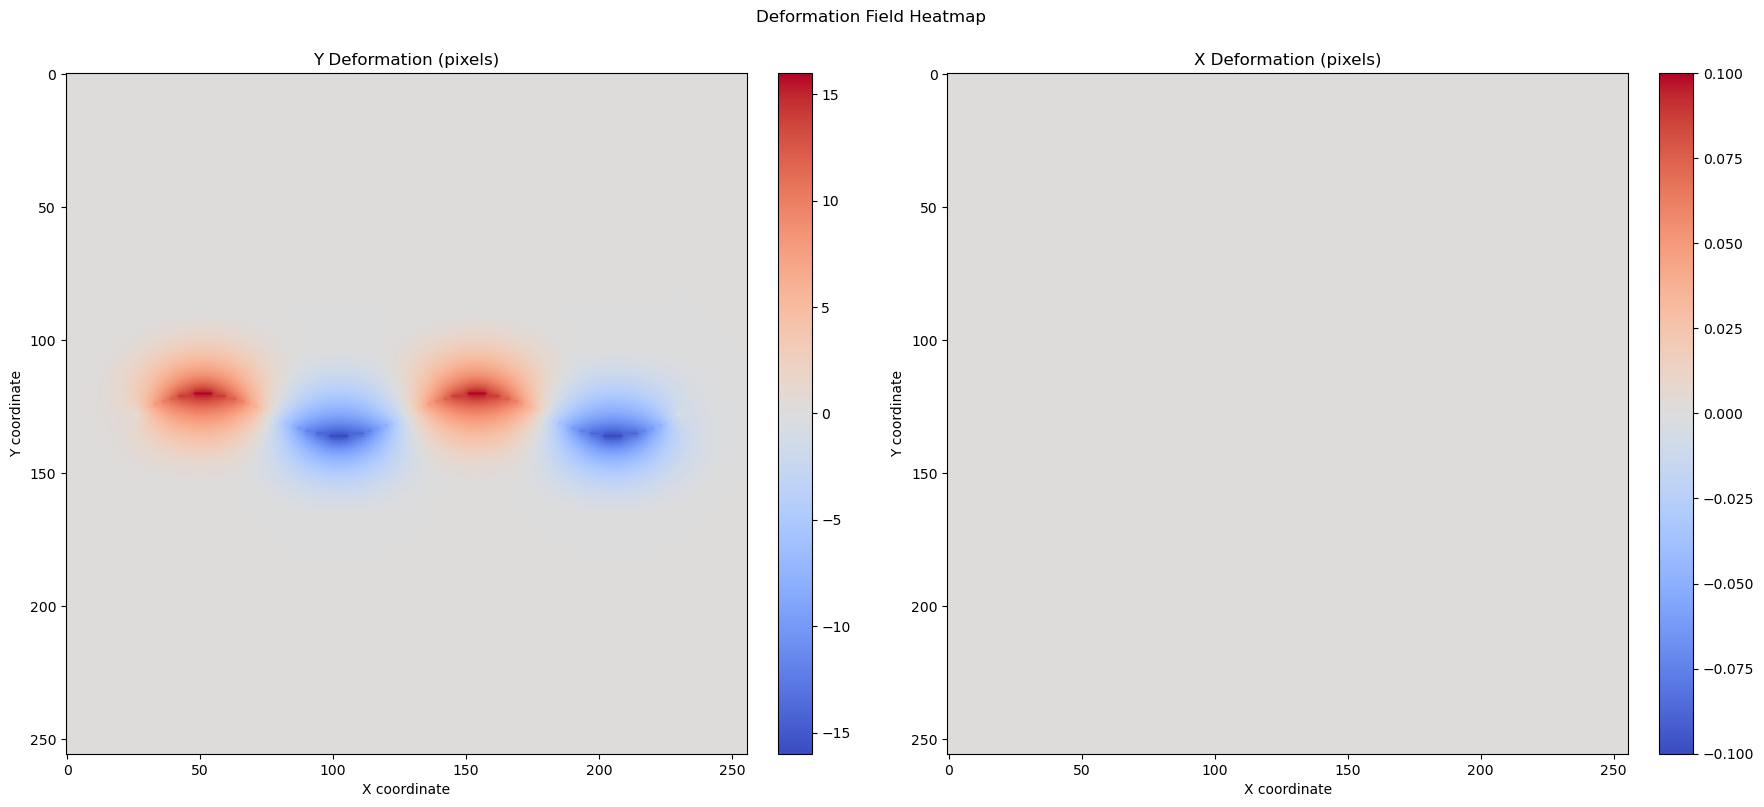

fdata.shape (1, 256, 256)
Time taken to create A:  0.0755612850189209
||Ax - b||: 1.51
Mean error at correspondences: 13.406647502292262


In [12]:
#####################################################################################################
# SETUP 
#####################################################################################################

# Create a specific double helix for correspondence analysis
print("\n=== Creating Double Helix for Point Correspondence ===")
helix_wave1, helix_wave2, _ = data_utils.create_double_helix_waves(
    grid_size=min(resolution),
    num_cycles=2,
    amplitude_ratio=0.03,
    phase_offset=np.pi,  # 180 degrees for maximum separation
    padding_ratio=0.1,
    plot=False, horizontal=False,  # Set horizontal to False for vertical helix
)

# Swap with other data if provided
if m_data is not None:
    helix_wave1 = m_data
if f_data is not None:
    helix_wave2 = f_data
    
# Move helix_waves aways from each other
helix_wave1[:, 1] += -shift_distance
helix_wave2[:, 1] += shift_distance

#helix_wave1[:, 1] += 20 # y
#helix_wave1[:, 0] += 20 # x

# Decrease point density for better visualization
helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

# Plot the correspondences between the two helical waves
data_utils.plot_point_correspondences(helix_wave1, helix_wave2,
                          labels=('Moving points', 'Fixed points'),
                          colors=('green', 'red'),
                          title='Point Correspondences',
                          show_indices=False,
                          line_alpha=0.2,  # More transparent lines to show the pattern better
                          point_size=20)

# Swap columns to match expected format (x, y)
helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

# Add 0s on the first axis to format for Data class
helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)

# Get the downwards and upwards clusters
try:
    cluster_indices, cluster_info = cluster.get_cluster_indices(helix_wave1, helix_wave2, method=cluster_method)
    down_indices = cluster_indices[0]
    up_indices = cluster_indices[1]
    raise Exception
except:
    print("ERROR: Error getting cluster indices. Ensure the points are in the correct format and the correct method is used (y_direction or x_direction). Using half of the points as down_indices and the other half as up_indices.")
    down_indices = [i for i in range(len(helix_wave1)//2)]
    up_indices = [i for i in range(len(helix_wave1)//2, len(helix_wave1))]

# Save to raw image
moving_img = data_utils.create_raw_image(helix_wave1, resolution, save_path="wave1.png")
fixed_img = data_utils.create_raw_image(helix_wave2, resolution, save_path="wave2.png")
data_utils.show_2_pngs(moving_img, fixed_img, title1="Moving Image", title2="Fixed Image")

#####################################################################################################
# Run Laplacian
#####################################################################################################

d = Data(helix_wave1, helix_wave2, resolution)
d_original = deepcopy(d)  # Save original data for later use

d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False, figsize=(10, 10),
       title=f"Full Laplacian, all points\nMin Jdet: {d.min():.2f}, Negatives: {d.count_negatives()}")
transformed_img = reg_utils.apply_transformation_fixed(d, moving_img, mpoints=d.mpoints, fpoints=d.fpoints, title="Transformed Image")
reg_utils.deformation_heatmap(d, title="Deformation Field Heatmap")

_, _, _, total_err = reg_utils.compute_error_fixed(d.resolution, helix_wave1, helix_wave2, d.deformation)
print(f"||Ax - b||: {total_err:.2f}")
errors = reg_utils.correspondence_error(d.deformation, helix_wave1, helix_wave2)
print("Mean error at correspondences:", np.mean(errors))
#rint("Max error at correspondences:", np.max(errors))

In [13]:
#down_indices_copy = deepcopy(down_indices)
#up_indices_copy = deepcopy(up_indices)
#down_indices = down_indices_copy
#up_indices = up_indices_copy

## Run on individual clusters

In [14]:
RUN_EXPERIMENT = False
if RUN_EXPERIMENT:
        # Run Laplacian on down indices
        d = Data(helix_wave1[down_indices], helix_wave2[down_indices], resolution)
        d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False, binarize_negatives=False, figsize=(10, 10),
                title="Down Cluster\nMin Jdet: {:.2f}, Negatives: {}".format(d.min(), d.count_negatives()))
        _ = reg_utils.apply_transformation_fixed(d, moving_img, mpoints=d.mpoints, fpoints=d.fpoints, title="Transformed Moving Image (Down cluster)")
        _, _, _, total_err = reg_utils.compute_error_fixed(d.resolution, helix_wave1[down_indices], helix_wave2[down_indices], d.deformation)
        print(f"Down cluster error: {total_err:.2f}")

        # Run Laplacian on up indices
        d = Data(helix_wave1[up_indices], helix_wave2[up_indices], resolution)
        d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False, binarize_negatives=False, figsize=(10, 10),
                title=f"Up Cluster\nMin Jdet: {d.min():.2f}, Negatives: {d.count_negatives()}")
        _ = reg_utils.apply_transformation_fixed(d, moving_img, mpoints=d.mpoints, fpoints=d.fpoints, title="Transformed Moving Image (Up cluster)")
        _, _, _, total_err = reg_utils.compute_error_fixed(d.resolution, helix_wave1[up_indices], helix_wave2[up_indices], d.deformation)
        print(f"Up cluster error: {total_err:.2f}")

## Laplacian clustering

In [15]:
def cluster_laplacian(moving_points, fixed_points, resolution, clusters, moving_img=None, verbose=True):
    """
    Apply manual cluster-wise deformation as in the 'Down first' block.
    Args:
        moving_points: np.ndarray, shape (N, 3)
        fixed_points: np.ndarray, shape (N, 3)
        resolution: tuple, image resolution
        clusters: list of lists/arrays, each contains indices for a cluster
        moving_img: optional, image for visualization
        verbose: bool, show plots and info
    Returns:
        d_combined: Data object with combined deformation
    """
    # Step 1: First cluster deformation
    cluster1_idx = clusters[0]
    cluster2_idx = clusters[1]
    d1 = Data(moving_points[cluster1_idx], fixed_points[cluster1_idx], resolution)
    if verbose:
        d1.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
                binarize_negatives=False, title=f"Cluster 1\nMin Jdet: {d1.min():.2f}, Negatives: {d1.count_negatives()}")
    if moving_img is not None:
        iter1 = reg_utils.apply_transformation_fixed(d1, moving_img, mpoints=moving_points, fpoints=fixed_points,
                                    title="Transformed Moving Image (Cluster 1)")
    else:
        iter1 = None

    # Step 2: Fix cluster 1 points, move cluster 2 points
    new_mpoints = moving_points.copy()
    new_fpoints = fixed_points.copy()
    new_mpoints[cluster1_idx] = new_fpoints[cluster1_idx]  # Fix moving points to fixed points

    for idx in cluster2_idx:
        curr_mcoord = moving_points[idx]
        curr_fcoord = fixed_points[idx]
        
        #curr_mcoord = np.round(curr_mcoord).astype(int)
        #curr_fcoord = np.round(curr_fcoord).astype(int)
        
        new_mdisplacement = d1.deformation[:, 0, np.round(curr_mcoord[1]).astype(int), np.round(curr_mcoord[2]).astype(int)]
        new_fdisplacement = d1.deformation[:, 0, np.round(curr_fcoord[1]).astype(int), np.round(curr_fcoord[2]).astype(int)]
        # Optionally use new_fdisplacement, but original code uses new_mdisplacement for both
        new_mcoord = curr_mcoord + new_mdisplacement
        new_mcoord = np.round(new_mcoord).astype(int)
        #new_fcoord = curr_fcoord + new_mdisplacement
        new_fcoord = curr_fcoord + new_fdisplacement  # Use same displacement for fixed points
        new_fcoord = np.round(new_fcoord).astype(int)
        new_mpoints[idx] = new_mcoord
        new_fpoints[idx] = new_fcoord

    # Step 4: New Data object with updated points
    d2 = Data(new_mpoints, new_fpoints, resolution)
    if verbose:
        d2.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
                binarize_negatives=False, title=f"Cluster 2\nMin Jdet: {d2.min():.2f}, Negatives: {d2.count_negatives()}")
    if moving_img is not None and iter1 is not None:
        iter2_reg = reg_utils.apply_transformation_fixed(d2, iter1, mpoints=moving_points, fpoints=fixed_points,
                                                   title="Transformed Moving Image (Cluster 2)")

    # Step 5: Combine deformation fields
    d_combined = Data(moving_points, fixed_points, resolution)
    d_combined.deformation = cluster.compose_deformation_fields(d1.deformation, d2.deformation)
    d_combined.jdet_field = jacobian.sitk_jacobian_determinant(d_combined.deformation)[0]
    if verbose:
        d_combined.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
                        title=f"Combined Deformation\nMin Jdet: {d_combined.min():.2f}, Negatives: {d_combined.count_negatives()}")
    if moving_img is not None:
        composed_reg = reg_utils.apply_transformation_fixed(d_combined, moving_img, mpoints=moving_points, fpoints=fixed_points,
                            title="Transformed Moving Image (Composed Deformation)")
        print("L2 difference between iteration 2 and composed deformation:", np.linalg.norm(iter2_reg - composed_reg))

    return d_combined



In [16]:
print(up_indices)
print(down_indices)

[103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]


In [17]:
# Get coordinates where 
d_original.get_negative_coordinates()

Negative Jacobian determinants:
(121, 48)
(121, 49)
(121, 50)
(121, 51)
(121, 52)
(121, 53)
(121, 54)
(121, 151)
(121, 152)
(121, 153)
(121, 154)
(121, 155)
(121, 156)
(121, 157)
(122, 42)
(122, 43)
(122, 59)
(122, 145)
(122, 146)
(122, 162)
(123, 39)
(123, 63)
(123, 142)
(123, 166)
(124, 66)
(124, 169)
(132, 87)
(132, 190)
(133, 90)
(133, 114)
(133, 193)
(133, 217)
(134, 94)
(134, 110)
(134, 111)
(134, 197)
(134, 213)
(134, 214)
(135, 99)
(135, 100)
(135, 101)
(135, 102)
(135, 103)
(135, 104)
(135, 105)
(135, 202)
(135, 203)
(135, 204)
(135, 205)
(135, 206)
(135, 207)
(135, 208)


array([[121,  48],
       [121,  49],
       [121,  50],
       [121,  51],
       [121,  52],
       [121,  53],
       [121,  54],
       [121, 151],
       [121, 152],
       [121, 153],
       [121, 154],
       [121, 155],
       [121, 156],
       [121, 157],
       [122,  42],
       [122,  43],
       [122,  59],
       [122, 145],
       [122, 146],
       [122, 162],
       [123,  39],
       [123,  63],
       [123, 142],
       [123, 166],
       [124,  66],
       [124, 169],
       [132,  87],
       [132, 190],
       [133,  90],
       [133, 114],
       [133, 193],
       [133, 217],
       [134,  94],
       [134, 110],
       [134, 111],
       [134, 197],
       [134, 213],
       [134, 214],
       [135,  99],
       [135, 100],
       [135, 101],
       [135, 102],
       [135, 103],
       [135, 104],
       [135, 105],
       [135, 202],
       [135, 203],
       [135, 204],
       [135, 205],
       [135, 206],
       [135, 207],
       [135, 208]], dtype=int64

In [18]:
pt = (120, 206)
current_jdet = d_original.jdet_field[pt[0], pt[1]]
current = d_original.deformation[:, 0, pt[0], pt[1]]
down = d_original.deformation[:, 0, pt[0]-1, pt[1]]
up = d_original.deformation[:, 0, pt[0]+1, pt[1]]
left = d_original.deformation[:, 0, pt[0], pt[1]-1]
right = d_original.deformation[:, 0, pt[0], pt[1]+1]

print("Mapping in moving space:")
print("Current point:", pt)
print("Jdet:", current_jdet)

print("Current:", current)
print("Down:", down)
print("Up:", up)
print("Left:", left)
print("Right:", right)

((down - up) / 2) - (right - left) / 2

Mapping in moving space:
Current point: (120, 206)
Jdet: 0.5593869953987345
Current: [ 0.         -4.68028805  0.        ]
Down: [ 0.       -4.250744  0.      ]
Up: [ 0.         -5.13197001  0.        ]
Left: [ 0.         -4.68026533  0.        ]
Right: [ 0.        -4.6645605  0.       ]


array([0.        , 0.43276059, 0.        ])

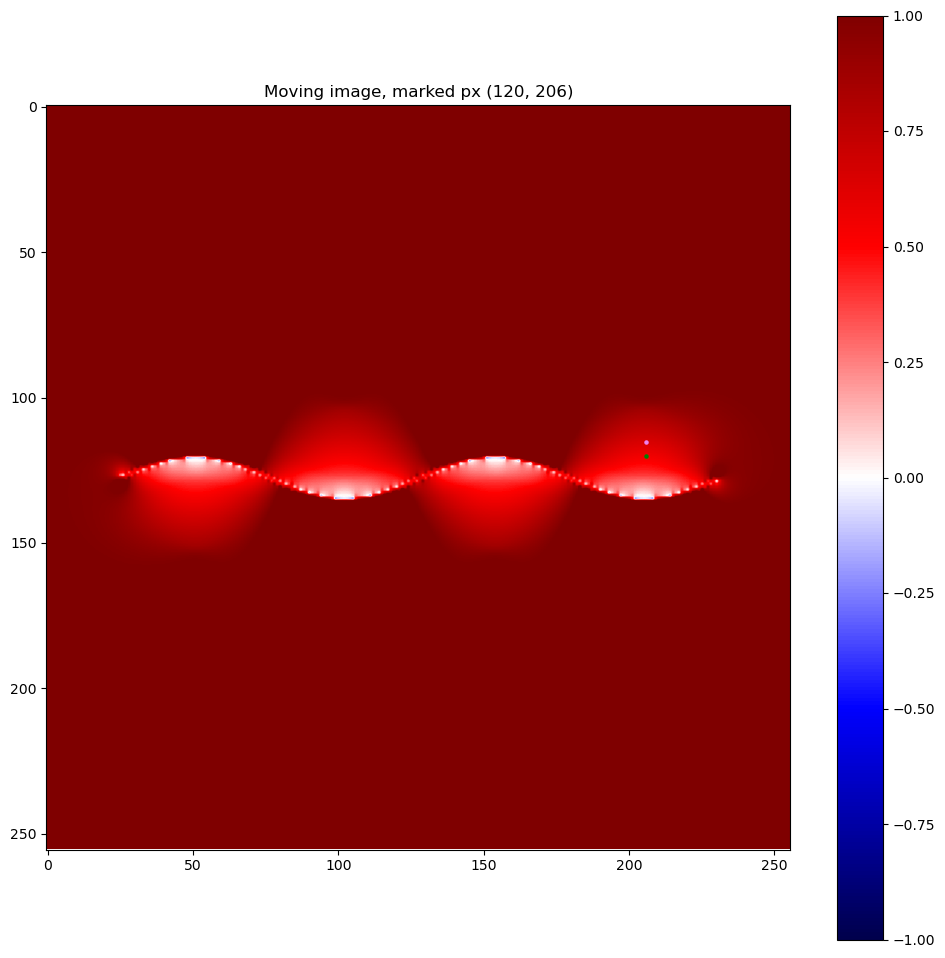

In [19]:
def show(d, px, figsize: tuple = (10, 5), fontsize: int = 6, show_text=True, show_axis=True, show_correspondence=True, show_orientation=False, binarize_negatives=False):
    """Show the deformation field and the Jacobian determinant field.
    
    Args:
        title (str, optional): Title of the plot. Defaults to None.
        figsize (tuple, optional): Size of the plot. Defaults to (10, 5).
        fontsize (int, optional): Font size of the text. Defaults to 6.
        show_text (bool, optional): Whether to show text on the plot. Defaults to True.
        show_axis (bool, optional): Whether to show the normalized axis text or use the default. Defaults to True.
    """
    #norm = mcolors.TwoSlopeNorm(vmin=min(self.jdet_field.min(), -1), vcenter=0, vmax=self.jdet_field.max())
    norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    
    jdet_field = d.jdet_field.copy()
    
    #if binarize_negatives:
    #    jdet_field[jdet_field < 0] = -1
    #    jdet_field[jdet_field > 0] = 1  # Clip values to [-1, 1] for better visualization

    f = plt.figure(figsize=figsize)
    plt.imshow(jdet_field, cmap="seismic", norm=norm)
    plt.colorbar()
    
    plt.scatter(px[1], px[0], c='green', s=5)
    plt.scatter(px[1] + d.deformation[2, 0, px[0], px[1]], px[0] + d.deformation[1, 0, px[0], px[1]], c='violet', s=5)
    plt.title(f"Moving image, marked px {px}")
    plt.show()
    f.clear()
    plt.close(f)
    
show(d, px=pt, figsize=(12, 12))

In [20]:
# Find the index of the row in an array where the values match (0, 120, 206)
def find_index(arr, values):
    """
    arr: np.ndarray of shape (N, 3)
    values: tuple or list of 3 values to match
    Returns: index or -1 if not found
    """
    matches = np.where(np.all(arr == values, axis=1))[0]
    return matches[0] if len(matches) > 0 else -1

# Example usage:
idx = find_index(helix_wave1, (0, 120, 206))
print("Index of (0, 120, 206):", idx)

print(helix_wave1[181])
print(helix_wave2[181])

#print(helix_wave1)

Index of (0, 120, 206): 181
[  0 120 206]
[  0 136 206]


### Down first

Down indices then up indices


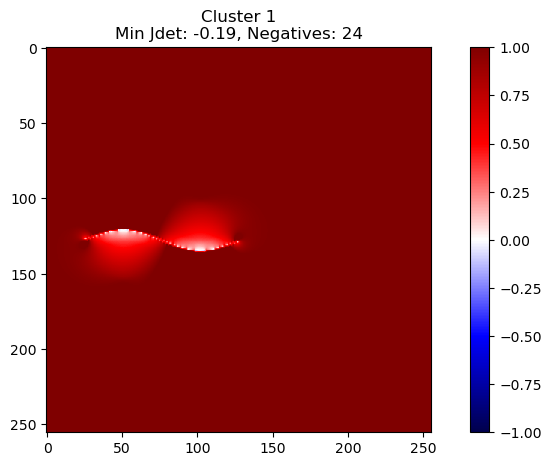

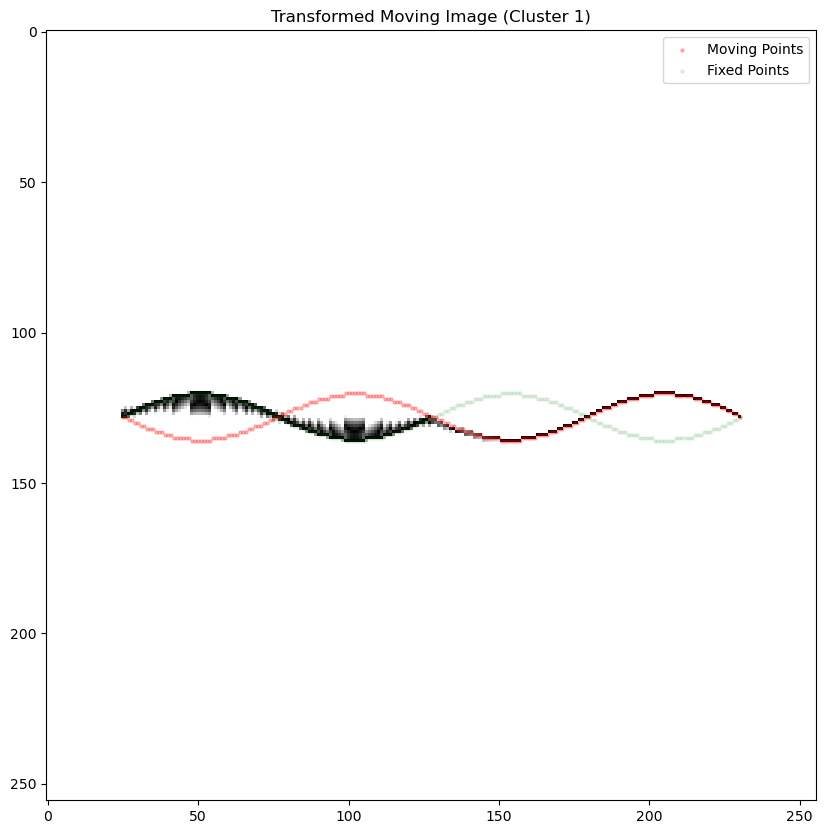

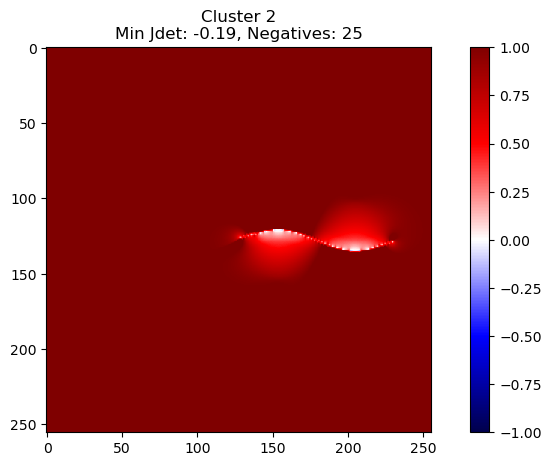

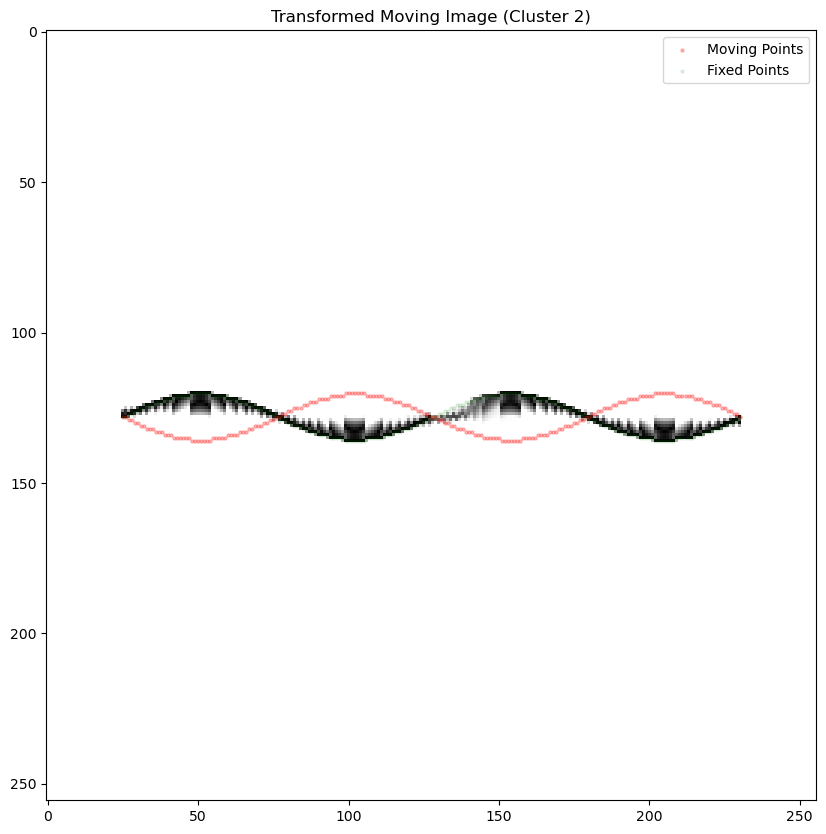

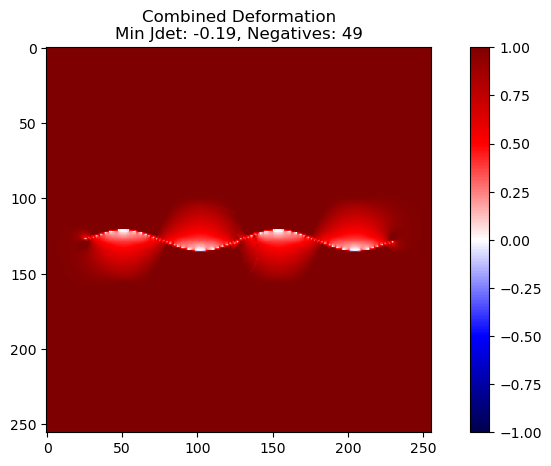

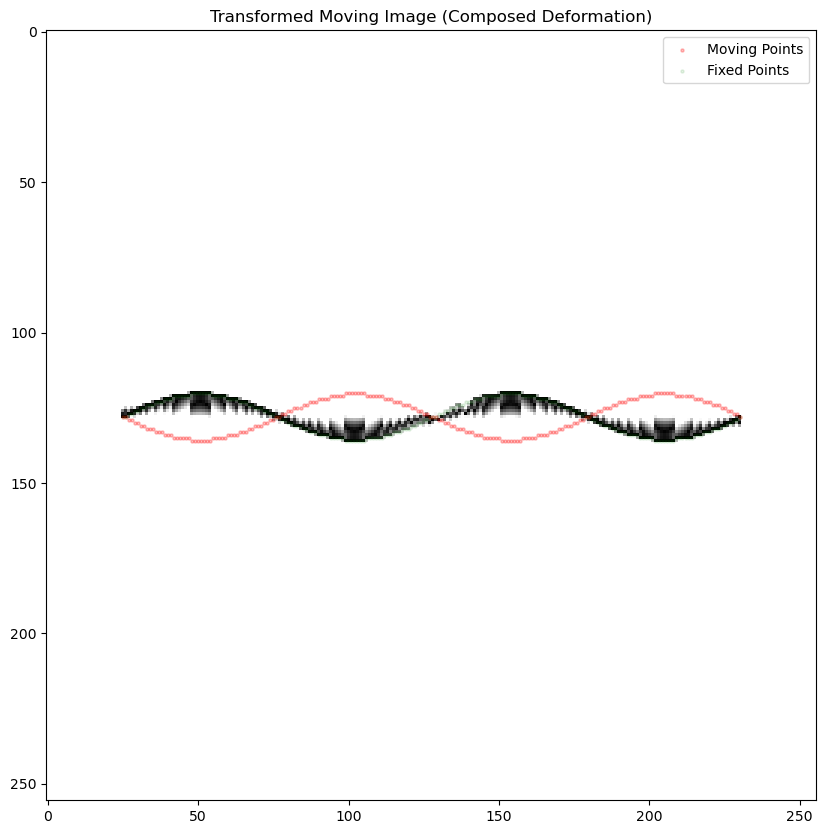

L2 difference between iteration 2 and composed deformation: 4.1245513
fdata.shape (1, 256, 256)
Time taken to create A:  0.07007837295532227
||Ax̂ - b|| for cluster-based deformation: 6.41
L2 error between original deformation and cluster-based deformation: 13.70
Mean error at correspondences: 13.460764124621075


In [21]:
print("Down indices then up indices")
d_result = cluster_laplacian(helix_wave1, helix_wave2, resolution, [down_indices, up_indices], moving_img)
_, _, _, total_err = reg_utils.compute_error_fixed(d_result.resolution, helix_wave1, helix_wave2, d_result.deformation)
print(f"||Ax̂ - b|| for cluster-based deformation: {total_err:.2f}")
print(f"L2 error between original deformation and cluster-based deformation: {np.linalg.norm(d_original.deformation - d_result.deformation):.2f}")
errors = reg_utils.correspondence_error(d_result.deformation, helix_wave1, helix_wave2)
print("Mean error at correspondences:", np.mean(errors))
#print("Max error at correspondences:", np.max(errors))

### Up first

Up indices then down indices


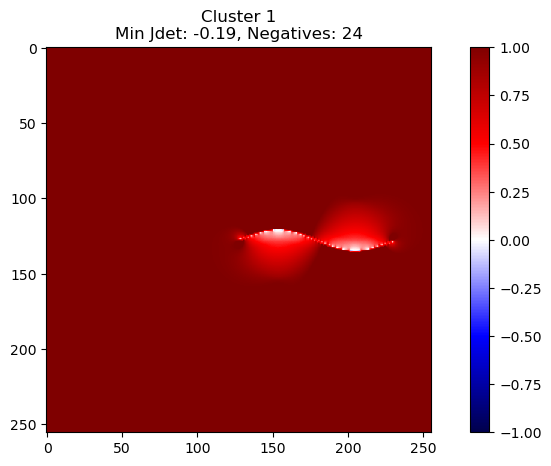

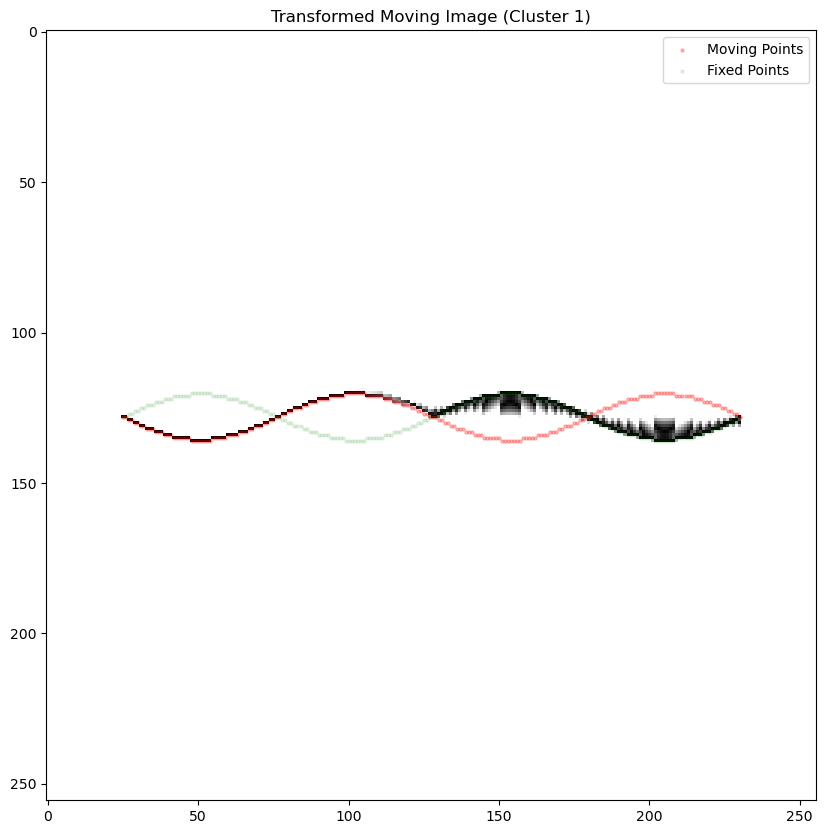

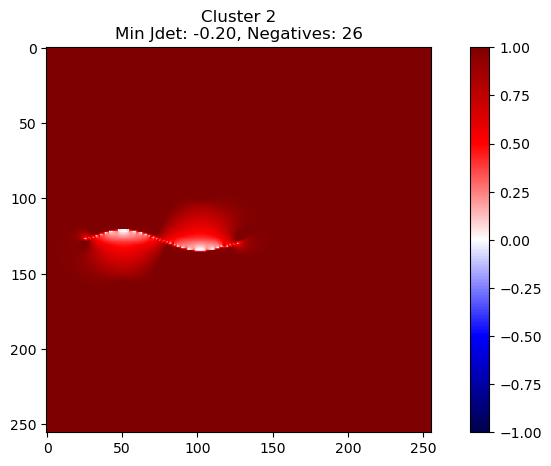

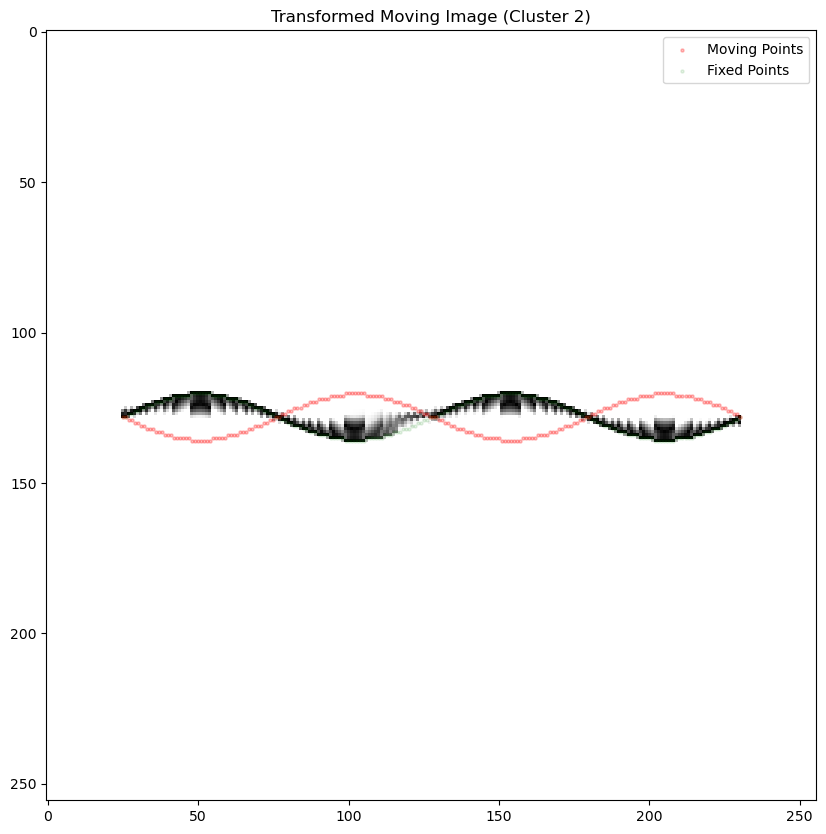

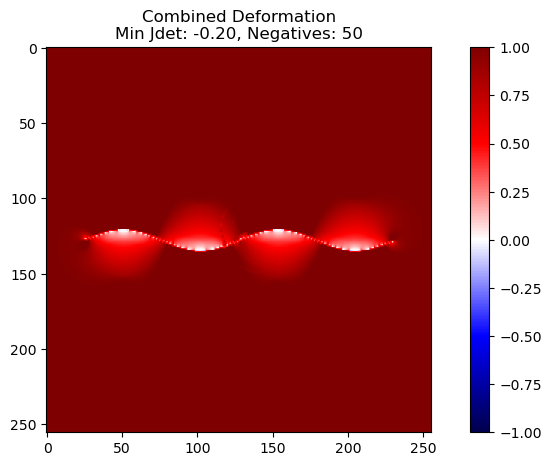

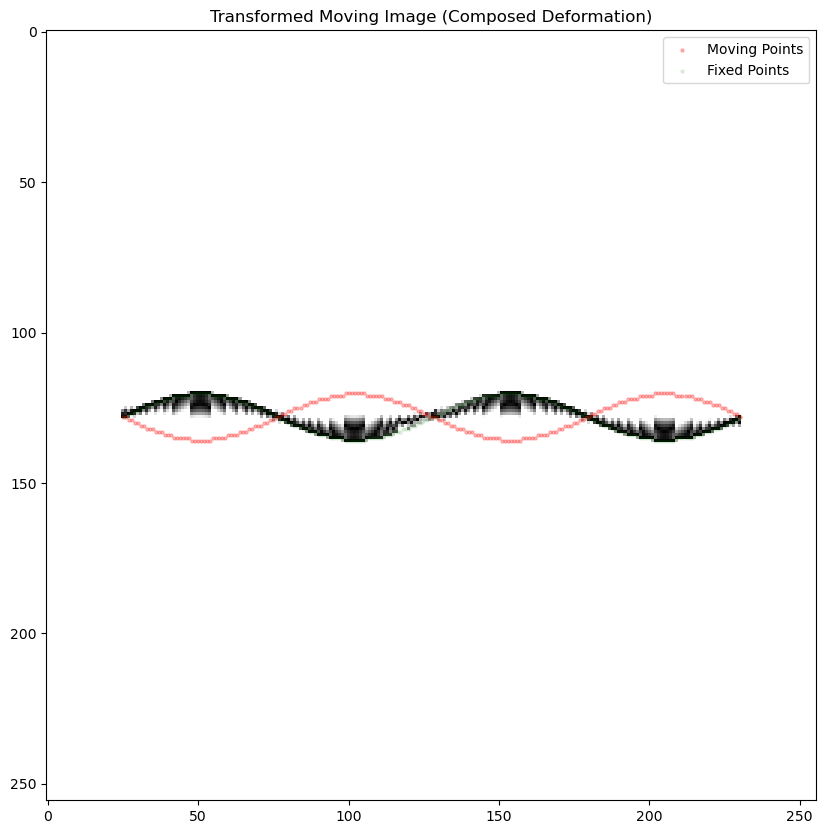

L2 difference between iteration 2 and composed deformation: 4.128187
fdata.shape (1, 256, 256)
Time taken to create A:  0.06357192993164062
||Ax̂ - b|| for cluster-based deformation: 6.83
L2 error between original deformation and cluster-based deformation: 11.39
Mean error at correspondences: 13.422537239923182


In [22]:
print("Up indices then down indices")
d_result = cluster_laplacian(helix_wave1, helix_wave2, resolution, [up_indices, down_indices], moving_img)
_, _, _, total_err = reg_utils.compute_error_fixed(d_result.resolution, helix_wave1, helix_wave2, d_result.deformation)
print(f"||Ax̂ - b|| for cluster-based deformation: {total_err:.2f}")
print(f"L2 error between original deformation and cluster-based deformation: {np.linalg.norm(d_original.deformation - d_result.deformation):.2f}")
errors = reg_utils.correspondence_error(d_result.deformation, helix_wave1, helix_wave2)
print("Mean error at correspondences:", np.mean(errors))
#print("Max error at correspondences:", np.max(errors))

# Run ANTs

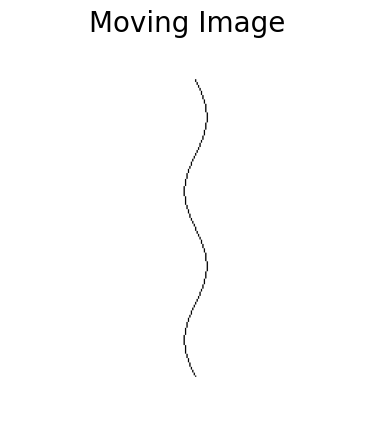

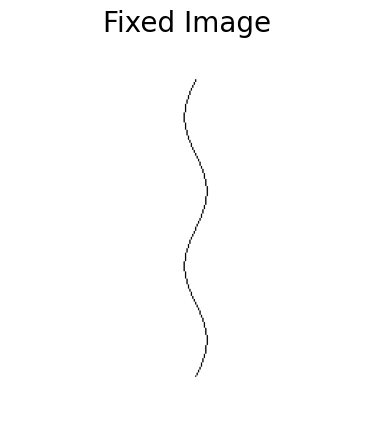

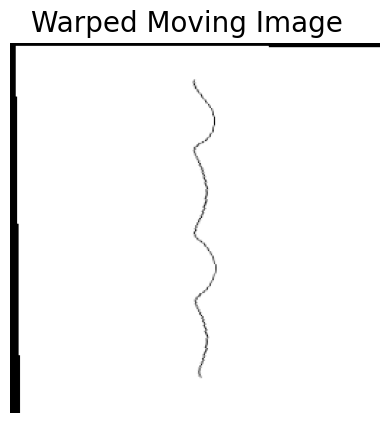

In [23]:
import ants

# Convert numpy arrays to ANTs images
moving_ants = ants.from_numpy(moving_img)
fixed_ants = ants.from_numpy(fixed_img)

# Perform registration (SyN is typical for nonrigid)
reg = ants.registration(
    fixed=fixed_ants,
    moving=moving_ants,
    type_of_transform='SyN'
)

# Get the warped image
warped_moving = reg['warpedmovout']

# Show result
ants.plot(moving_ants, title='Moving Image')
ants.plot(fixed_ants, title='Fixed Image')
ants.plot(warped_moving, title='Warped Moving Image')

# Laplacian upscaling

When we have jacobian det >1, give it more weighting

Fixed image mapping: increase resolution 3x bigger

For all the known original pixels assign the backward mapping, the corresponding points

Interpolate these correspondences throughout the images to include all the new pixels that we introduced because of upscaling. 

Wherever we upscale the interpolation, wherever we have a group of > 1 jacobians in the original pixels, find the round-off interpolated value, then go back to the corresponding pixel in the other space. (if increasing by 3, then 0.33, 0.66 in that other resolution). 

136, 137 is above jacobian, we look for 4 adjacent pixels above 1 jacobian

When interpolating we see that interpolating corresponding

136 -> 120

137 -> 122.4

Interpolating between 120 122,4 and assigning to 136.3 and 136.66

In the original image, we see which interpolated value is closest, see what is its value, 

120.8 -> 121, 136.33 -> 136

Do the same thing for moving image. 

Make sure two pixels do not map to the same point.

In [126]:
import numpy as np
from scipy.ndimage import zoom


def get_point_info(dvf, pt, scale=1):
    """
    Get the current point's deformation and Jdet information.
    Args:
        d_original: Data object containing the deformation field and Jdet field.
        pt: Tuple (y, x) coordinates of the point in the image.
    Returns:
        current_jdet: Jacobian determinant at the current point.
        current: Deformation vector at the current point.
        down: Deformation vector at the point below.
        up: Deformation vector at the point above.
        left: Deformation vector at the point to the left.
        right: Deformation vector at the point to the right.
    """
    pt = np.array(pt)
    current_jdet = jacobian.sitk_jacobian_determinant(dvf)[0][pt[0], pt[1]]
    current = dvf[:, 0, pt[0], pt[1]]
    down = dvf[:, 0, pt[0]-1, pt[1]]
    up = dvf[:, 0, pt[0]+1, pt[1]]
    left = dvf[:, 0, pt[0], pt[1]-1]
    right = dvf[:, 0, pt[0], pt[1]+1]

    print("Mapping in fixed space:")
    print(f"Current point: {np.array(pt) / scale}")
    print("Mapped point:", np.array((pt[0] / scale + current[1], pt[1] / scale + current[2])))
    print("Jdet:", current_jdet)

    print("Current displacement:", current)
    #print("\tDown:", down)
    #print("\tUp:", up)
    #print("\tLeft:", left)
    #print("\tRight:", right)
    print()


def upscale_dvf_preserve(dvf, scale=3):
    """
    Upscales a DVF (3, 1, H, W) by a factor with linear interpolation.
    Ensures original values at original locations are preserved.

    Parameters:
        dvf (np.ndarray): Deformation vector field of shape (3, 1, H, W)
        scale (int): Upscaling factor (e.g., 3)

    Returns:
        np.ndarray: Upscaled DVF of shape (3, 1, scale*H, scale*W)
    """
    z, c, H, W = dvf.shape
    # Linearly interpolate entire DVF
    dvf_up = zoom(dvf, zoom=(1, 1, scale, scale), order=1)

    # Replace exact original points at the scaled locations (0, scale, 2*scale, ...)
    for y in range(H):
        for x in range(W):
            y_up = y * scale
            x_up = x * scale
            dvf_up[:, 0, y_up, x_up] = dvf[:, 0, y, x]

    return dvf_up


def get_expanding_coordinates(jdet_field, threshold=1, verbose=True):
    """
    Get the coordinates of expanding Jacobian determinants in the grid.
    
    Args:
        show (bool): Whether to print the coordinates of the expanding Jacobian determinants.
        
    Returns:
        np.ndarray: Array of coordinates of expanding Jacobian determinants.
    """
    # Get coordinate of expanding Jacobian determinants
    found_indices = np.argwhere(jdet_field > threshold)
    if verbose:
        print("Expanding Jacobian determinants:")
        for y, x in found_indices:
            print(f"({y}, {x})")
    print(f"Found {len(found_indices)} expanding Jacobian determinants with threshold {threshold}.")
    return found_indices

In [127]:
# Create a specific double helix for correspondence analysis
print("\n=== Creating Double Helix for Point Correspondence ===")
mpoints, fpoints, _ = data_utils.create_double_helix_waves(
    grid_size=256,
    num_cycles=2,
    amplitude_ratio=0.03,
    phase_offset=np.pi,  # 180 degrees for maximum separation
    padding_ratio=0.1,
    plot=False, horizontal=False,  # Set horizontal to False for vertical helix
)
mpoints = mpoints[:, [1, 0]]  # Swap to (y, x) format
fpoints = fpoints[:, [1, 0]]  # Swap to (y, x) format 

# Add 0s on the first axis to format for Data class
mpoints = np.pad(mpoints, ((0, 0), (1, 0)), mode='constant', constant_values=0)
fpoints = np.pad(fpoints, ((0, 0), (1, 0)), mode='constant', constant_values=0)

d_fixed = Data(mpoints, fpoints, (256, 256))
#d_fixed.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False, figsize=(10, 10),
#       title=f"Full Laplacian, fixed mapping\nMin Jdet: {d_fixed.min():.2f}, Negatives: {d_fixed.count_negatives()}")

fixed_upscaled = upscale_dvf_preserve(d_fixed.deformation, scale=3)

expanding_coord = get_expanding_coordinates(d_fixed.jdet_field, threshold=1.2, verbose=False)


=== Creating Double Helix for Point Correspondence ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Found 3810 expanding Jacobian determinants with threshold 1.2.


In [119]:
correspondence_pt = (137 * 3, 206 * 3)
get_point_info(dvf_up, correspondence_pt, scale=3) # Correspondence

Mapping in fixed space:
Current point: [137. 206.]
Mapped point: [122.3294591 206.       ]
Jdet: 1.4356628224022518
Current displacement: [  0.        -14.6705409   0.       ]



In [ ]:
correspondence_pt = (136, 206)
get_point_info(d_original, (132, 206))
get_point_info(d_original, (133, 206))
get_point_info(d_original, (134, 206))
get_point_info(d_original, (135, 206))
get_point_info(d_original, correspondence_pt) # Correspondence
get_point_info(d_original, (137, 206))
get_point_info(d_original, (138, 206))

Setup the original 256x256 points


=== Creating Double Helix for Point Correspondence ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
(206, 3) (206, 3)


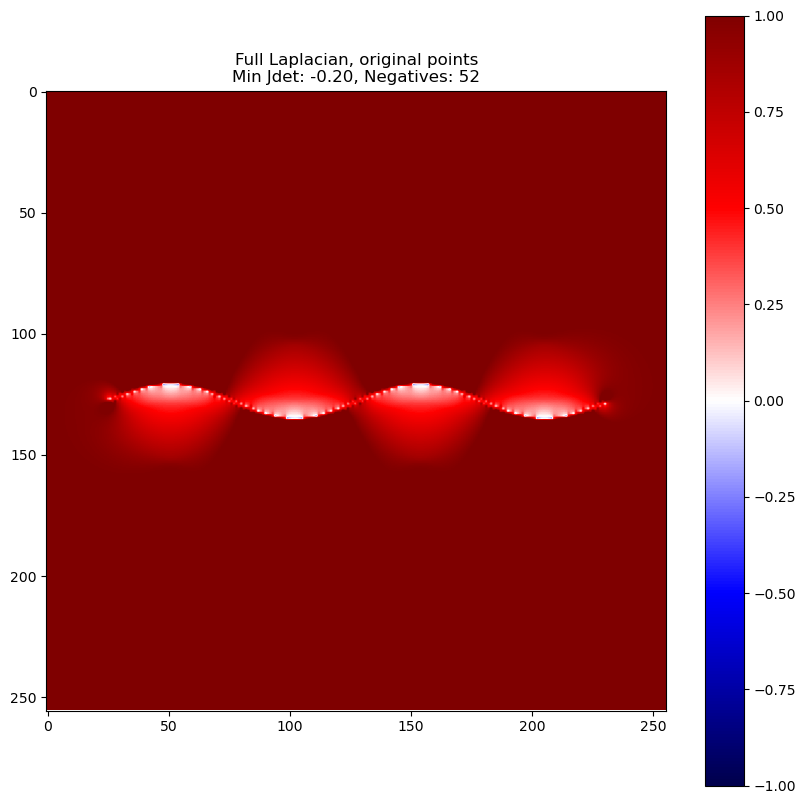

Plotted 206 point correspondences
Set 1 - X range: [75.0, 690.0], Y range: [360.0, 408.0]
Set 2 - X range: [75.0, 690.0], Y range: [360.0, 408.0]
Correspondence distances - Mean: 29.36, Std: 14.50, Max: 48.00


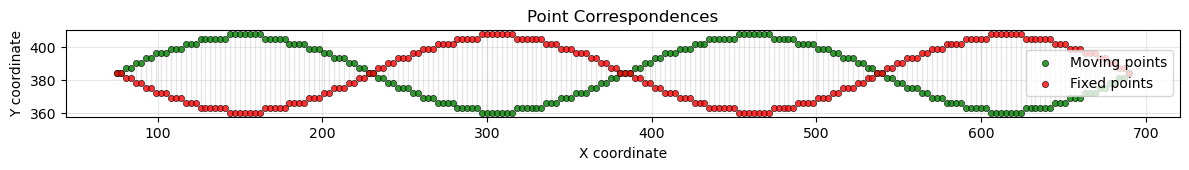

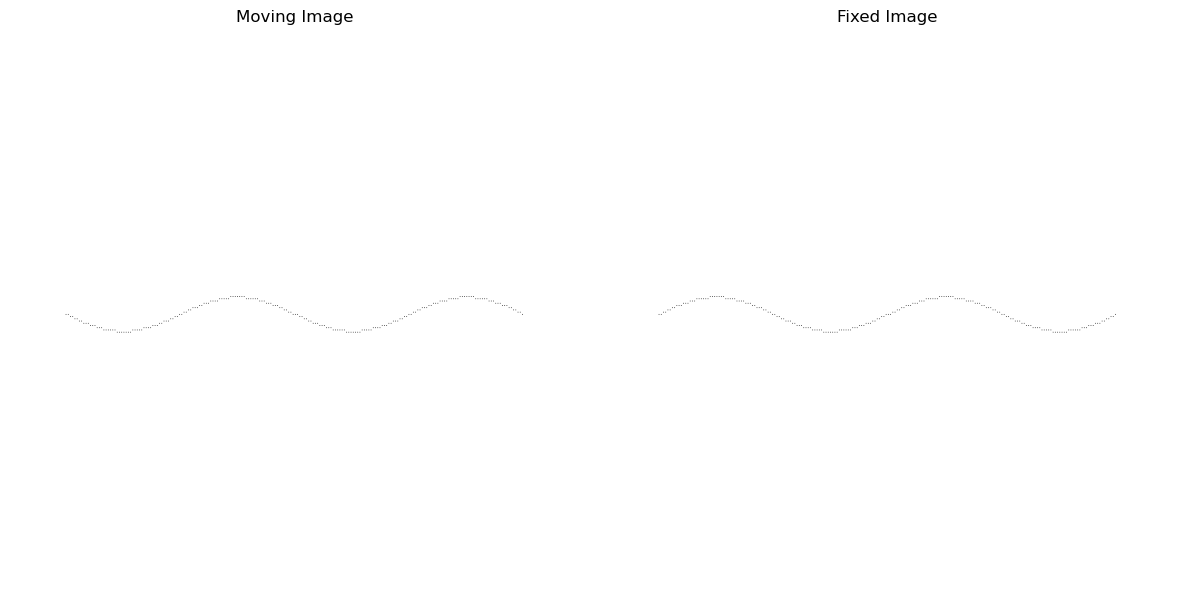

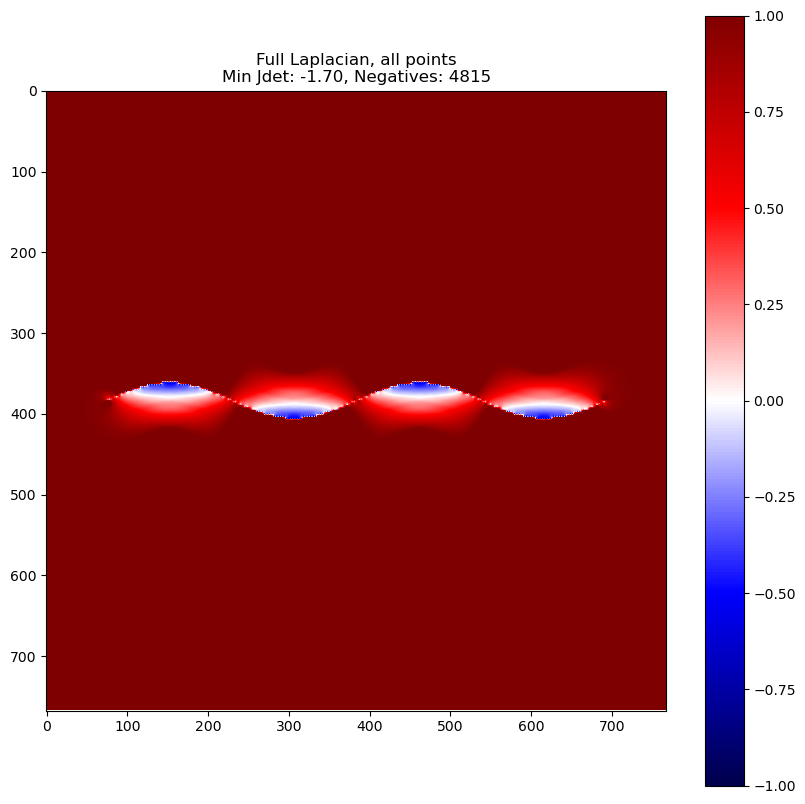

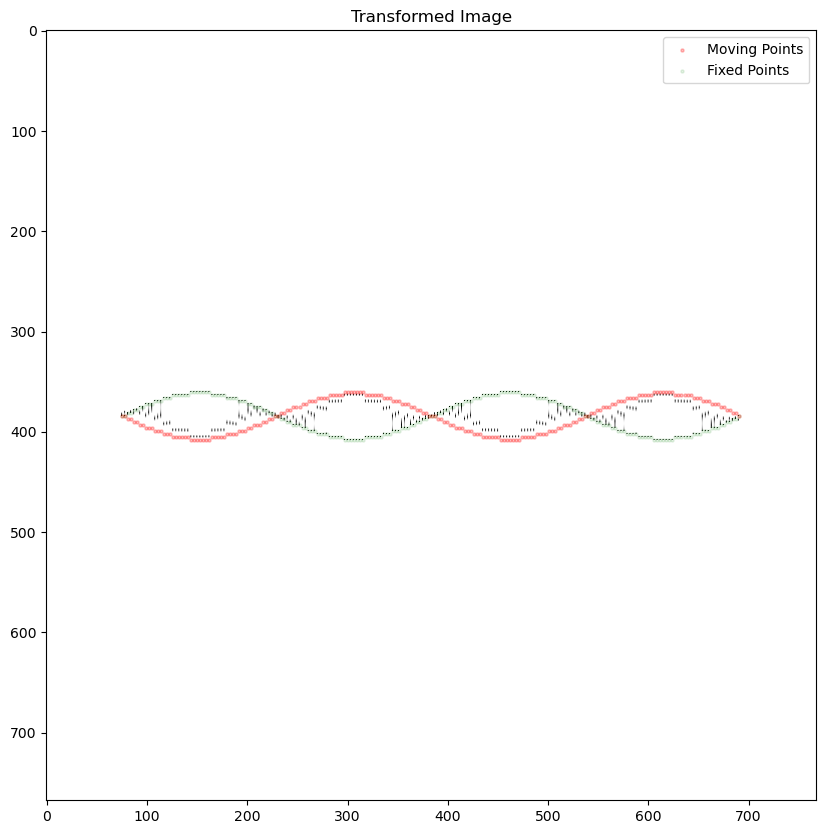

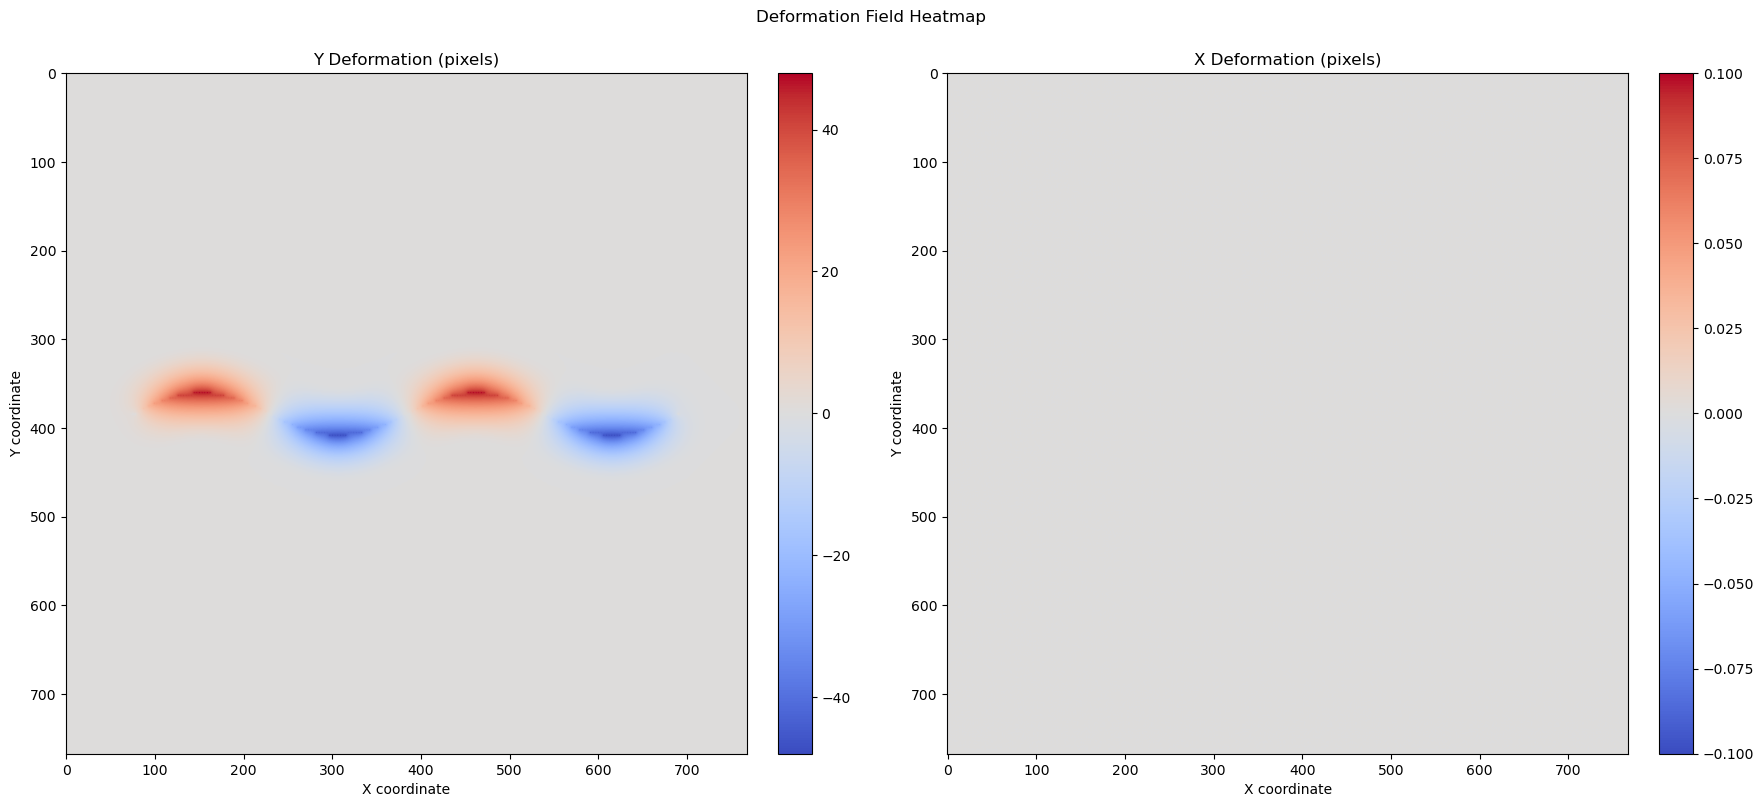

fdata.shape (1, 768, 768)
Time taken to create A:  0.13858294486999512
||Ax - b||: 4.63
Mean error at correspondences: 33.50464576697938


In [59]:
resolution = (256 * 3, 256 * 3)  # resolution for the data

#####################################################################################################
# SETUP 
#####################################################################################################

# Create a specific double helix for correspondence analysis
print("\n=== Creating Double Helix for Point Correspondence ===")
original_mpoints, original_fpoints, _ = data_utils.create_double_helix_waves(
    grid_size=256,
    num_cycles=2,
    amplitude_ratio=0.03,
    phase_offset=np.pi,  # 180 degrees for maximum separation
    padding_ratio=0.1,
    plot=False, horizontal=False,  # Set horizontal to False for vertical helix
)

# Scale the points up by a factor of 3 to fit a larger image resolution
mpoints = original_mpoints.copy() * 3
fpoints = original_fpoints.copy() * 3

# Swap columns to match expected format (x, y)
original_mpoints = original_mpoints[:, [1, 0]]  # Swap to (y, x) format
original_fpoints = original_fpoints[:, [1, 0]]  # Swap to (y, x) format 

# Add 0s on the first axis to format for Data class
original_mpoints = np.pad(original_mpoints, ((0, 0), (1, 0)), mode='constant', constant_values=0)
original_fpoints = np.pad(original_fpoints, ((0, 0), (1, 0)), mode='constant', constant_values=0)

#original_mpoints = np.vstack([original_mpoints, np.array([0, 119, 206])])
#original_fpoints = np.vstack([original_fpoints, np.array([0, 134, 206])])

print(original_mpoints.shape, original_fpoints.shape)

d_original = Data(original_mpoints, original_fpoints, (256, 256))
d_original.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False, figsize=(10, 10),
       title=f"Full Laplacian, original points\nMin Jdet: {d_original.min():.2f}, Negatives: {d_original.count_negatives()}")

# Plot the correspondences between the two helical waves
data_utils.plot_point_correspondences(mpoints, fpoints,
                          labels=('Moving points', 'Fixed points'),
                          colors=('green', 'red'),
                          title='Point Correspondences',
                          show_indices=False,
                          line_alpha=0.2,  # More transparent lines to show the pattern better
                          point_size=20)

# Swap columns to match expected format (x, y)
mpoints = mpoints[:, [1, 0]]  # Swap to (y, x) format
fpoints = fpoints[:, [1, 0]]  # Swap to (y, x) format 

# Add 0s on the first axis to format for Data class
mpoints = np.pad(mpoints, ((0, 0), (1, 0)), mode='constant', constant_values=0)
fpoints = np.pad(fpoints, ((0, 0), (1, 0)), mode='constant', constant_values=0)

# Save to raw image
moving_img = data_utils.create_raw_image(mpoints, resolution, save_path="mpoints.png")
fixed_img = data_utils.create_raw_image(fpoints, resolution, save_path="fpoints.png")
data_utils.show_2_pngs(moving_img, fixed_img, title1="Moving Image", title2="Fixed Image")

#####################################################################################################
# Run Laplacian
#####################################################################################################

d = Data(mpoints, fpoints, resolution)  # Use larger resolution to fit the scaled points

d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False, figsize=(10, 10),
       title=f"Full Laplacian, all points\nMin Jdet: {d.min():.2f}, Negatives: {d.count_negatives()}")
transformed_img = reg_utils.apply_transformation_fixed(d, moving_img, mpoints=d.mpoints, fpoints=d.fpoints, title="Transformed Image")
reg_utils.deformation_heatmap(d, title="Deformation Field Heatmap")

_, _, _, total_err = reg_utils.compute_error_fixed(d.resolution, mpoints, fpoints, d.deformation)
print(f"||Ax - b||: {total_err:.2f}")
errors = reg_utils.correspondence_error(d.deformation, mpoints, fpoints)
print("Mean error at correspondences:", np.mean(errors))
#rint("Max error at correspondences:", np.max(errors))


In [60]:
#d_original = np.load("d_moving.npy", allow_pickle=True).item()

In [43]:
d_original.mpoints[181]

array([  0, 120, 206])

Mapping in fixed space:
Current point: (132, 206)
Mapped point: (138.61380371925867, 206.0)
Jdet: 0.4728035766048042
	Current: [0.         6.61380372 0.        ]
	Down: [0.        7.1528487 0.       ]
	Up: [0.         6.09845586 0.        ]
	Left: [0.         6.61521759 0.        ]
	Right: [0.         6.59099419 0.        ]

Mapping in fixed space:
Current point: (133, 206)
Mapped point: (139.09845585717926, 206.0)
Jdet: 0.49534432121354666
	Current: [0.         6.09845586 0.        ]
	Down: [0.         6.61380372 0.        ]
	Up: [0.         5.60449236 0.        ]
	Left: [0.         6.09918582 0.        ]
	Right: [0.         6.07749927 0.        ]

Mapping in fixed space:
Current point: (134, 206)
Mapped point: (139.60449236168577, 206.0)
Jdet: 0.5167570781033017
	Current: [0.         5.60449236 0.        ]
	Down: [0.         6.09845586 0.        ]
	Up: [0.         5.13197001 0.        ]
	Left: [0.         5.60494976 0.        ]
	Right: [0.         5.58532786 0.        ]

Mapping in f

I have an optimization problem where I have a discrete grid of pixels, and I am applying a registration problem to it. 

Given correspondence points, which is a set of moving points that map to a set of fixed points, a displacement vector field is computed that gives the displacement of which moving point maps to each fixed point. 

One problem is that some moving points will map to the same fixed point due to floating point displacements and discretization of coordinates into integers. 
This causes issues of folding which is represented by negative Jacobian determinants.

To fix this and reduce the number of negative Jacobian determinants, I want to take the original set of correspondences and upscale them 3x and optimize that grid for displacements. As I go through the upscaled grid, I want to look at the intermediary pixels added by the upscaling and use those displacement values to approximate more correspondences in the original resolution by assigning these points to an approximate pixel correspondence and adding them to the set of correspondences so we can recompute them in the original space with less negative Jacobian determinant values so the displacements of non correspondence pixels won't map to the same points as others or illogical positions. 

We have noticed pixels with higher (greater than 1 Jacobian determinant values) are good candidates to compute this from. 

How would I go about doing this and how would I code this in Python?

___

You're trying to reduce folding (negative Jacobian determinants) in a registration problem on a discrete pixel grid by:

Upscaling the grid (e.g. 3× resolution).

Interpolating new displacement vectors at intermediate pixels in the upscaled space.

Selecting valid interpolated displacements (e.g. from regions with high Jacobian determinants).

Downsampling these new points as additional correspondences.

Recomputing the displacement field in the original resolution with the enriched set of correspondences.



In [45]:
def jacobian_plot(d, pt=None, figsize=(10, 5), title=None, 
                  xlim=None, ylim=None, 
                  binarize_negatives=False):
    """
    Plot the Jacobian determinant field.
    Args:
        d: Data object containing the deformation field and Jdet field.
        figsize: Size of the plot.
        title: Title of the plot.
    """
    jdet_field = d.jdet_field.copy()

    if binarize_negatives:
        jdet_field[jdet_field < 0] = -1
        #jdet_field[jdet_field > 0] = 1
        
    plt.figure(figsize=figsize)
    plt.imshow(jdet_field, cmap='seismic', vmin=-1, vmax=1)
    plt.colorbar()
    
    # Show Jdet value at all pixels in xlim and ylim
    if xlim is not None and ylim is not None:
        for y in range(ylim[0] + 1, ylim[1]):
            for x in range(xlim[0] + 1, xlim[1]):
                # If negative, show in red bold
                if jdet_field[y, x] < 0:
                    plt.text(x, y, f"{d.jdet_field[y, x]:.2f}", fontsize=7, ha='center', va='center', color='red', fontweight='bold')
                else:
                    plt.text(x, y, f"{d.jdet_field[y, x]:.2f}", fontsize=7, ha='center', va='center', color='black')

    if pt is not None:
        plt.scatter(pt[1], pt[0], c='green', s=20)
        plt.scatter(pt[1] + d.deformation[2, 0, pt[0], pt[1]], 
                    pt[0] + d.deformation[1, 0, pt[0], pt[1]], 
                    c='violet', s=20)
        plt.title(f"Moving image, marked px {pt}")
    else:
        plt.title("Jacobian Determinant Field")
    if title:
        plt.title(title)
    if xlim:
        plt.xlim(xlim)
        plt.xticks(ticks=np.arange(xlim[0], xlim[1], 1), labels=np.arange(xlim[0], xlim[1], 1))
    if ylim:
        plt.ylim(ylim)
        plt.yticks(ticks=np.arange(ylim[0], ylim[1], 1), labels=np.arange(ylim[0], ylim[1], 1))
    plt.grid(True, which='both', linestyle='--', linewidth=0.25)
    
    plt.show()

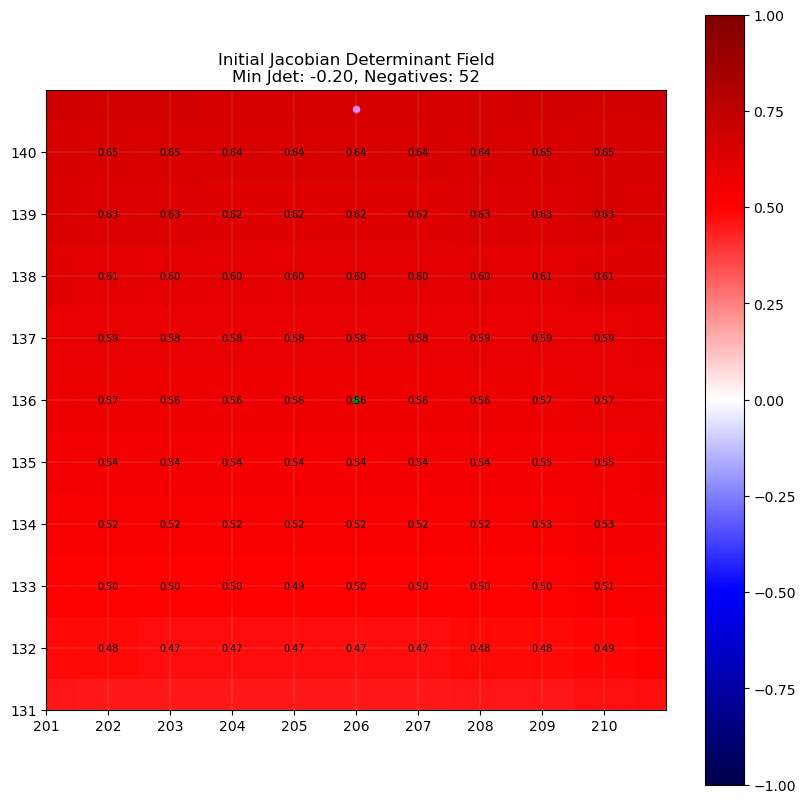

In [46]:
jacobian_plot(d_original, pt=correspondence_pt, figsize=(10, 10), title="Initial Jacobian Determinant Field\nMin Jdet: {:.2f}, Negatives: {}".format(d_original.min(), d_original.count_negatives()),
              xlim=(correspondence_pt[1] - 5, correspondence_pt[1] + 5), 
              ylim=(correspondence_pt[0] - 5, correspondence_pt[0] + 5), 
              binarize_negatives=True)

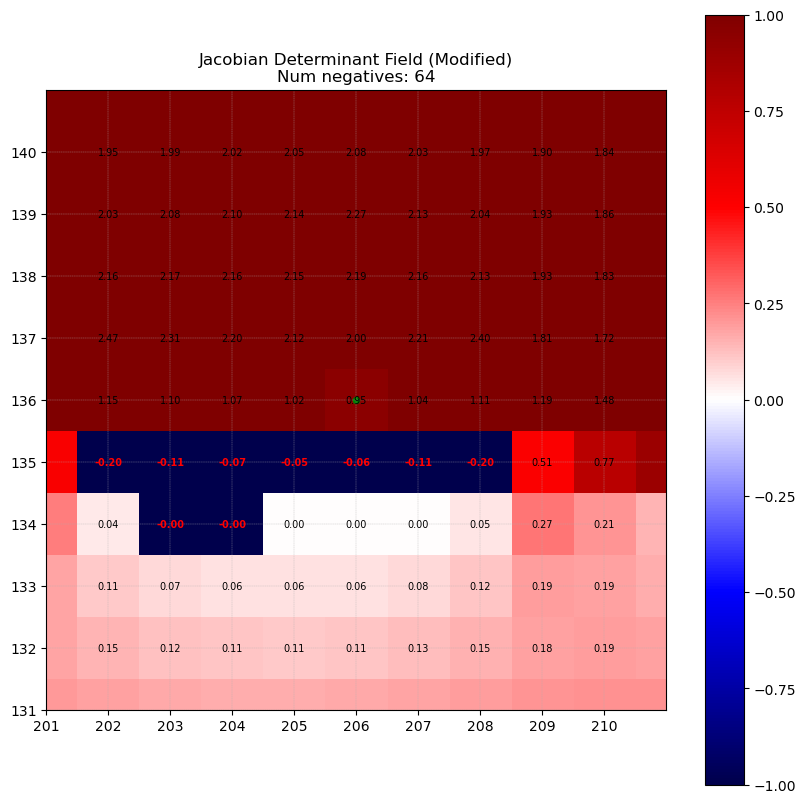

In [47]:
fpoints_to_add = np.array([
    #[0, 134, 206],
    [0, 137, 206],
    [0, 138, 206]
])

mpoints_to_add = np.array([
    #[0, 120, 206], #[0, 120, 206],
    [0, 122, 206], #[0, 118, 206],
    [0, 124, 206],
])


#Fixed [131 206] assigned to Moving [119 206] with displacement [-11.18071339   0.        ]
#Fixed [132 206] assigned to Moving [118 206] with displacement [-12.02943523   0.        ]
#Fixed [133 206] assigned to Moving [120 206] with displacement [-12.92931303   0.        ]
#Fixed [134 206] assigned to Moving [122 206] with displacement [-13.88402917   0.        ]
#Fixed [135 206] assigned to Moving [121 206] with displacement [-14.90782769   0.        ]

new_mpoints = deepcopy(d_original.mpoints)
new_fpoints = deepcopy(d_original.fpoints)

# Add new points to the moving and fixed points
try:
    new_mpoints = np.vstack([new_mpoints, mpoints_to_add])
    new_fpoints = np.vstack([new_fpoints, fpoints_to_add])
except:
    print("ERROR!")

d_copy = Data(new_mpoints, new_fpoints, resolution)

jacobian_plot(d_copy, pt=correspondence_pt, figsize=(10, 10), title="Jacobian Determinant Field (Modified)\nNum negatives: {}".format(d_copy.count_negatives()), 
              xlim=(correspondence_pt[1] - 5, correspondence_pt[1] + 5), 
              ylim=(correspondence_pt[0] - 5, correspondence_pt[0] + 5), 
              binarize_negatives=True)

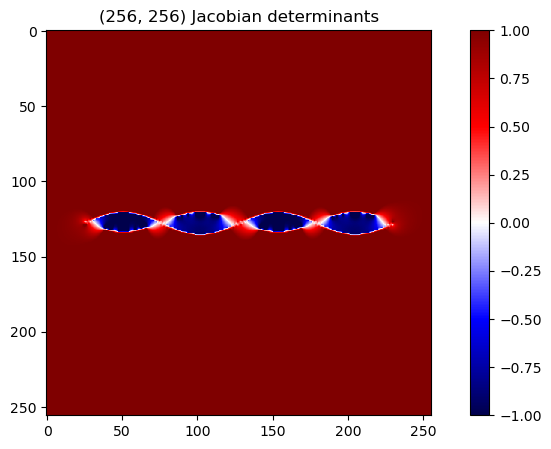

Min Jdet: -2.34, Negatives: 1708


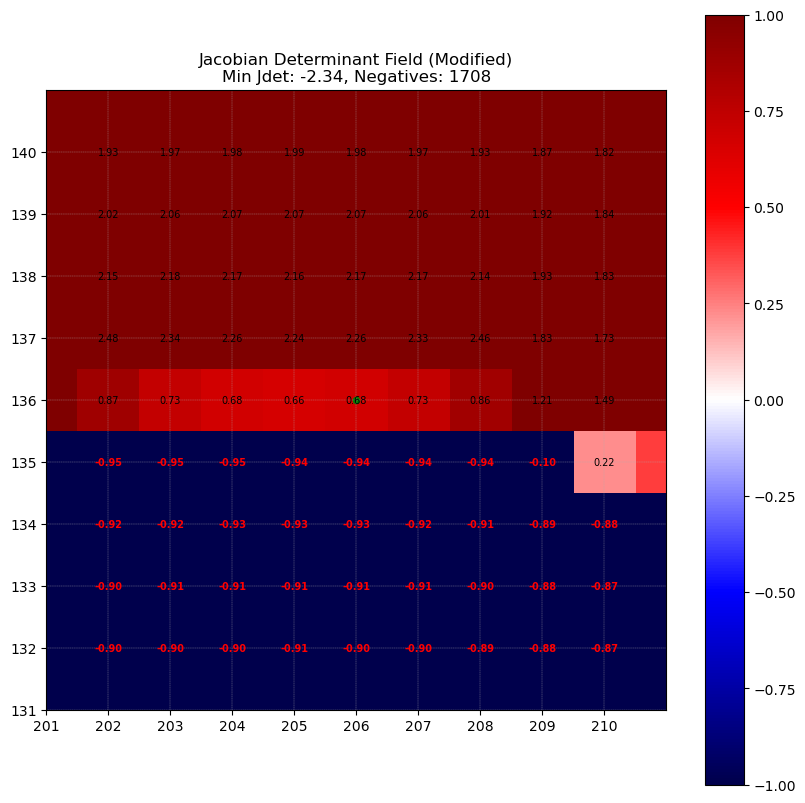

In [48]:
import numpy as np

def get_adjacent_coords(y, x, shape, connectivity=4):
    """Return list of valid adjacent (y, x) coordinates."""
    neighbors = []
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            if dy == 0 and dx == 0:
                continue
            if connectivity == 4 and abs(dy) + abs(dx) != 1:
                continue
            ny, nx = y + dy, x + dx
            if 0 <= ny < shape[0] and 0 <= nx < shape[1]:
                neighbors.append((0, ny, nx))
    return neighbors

def get_adjacent_coords(y, x, shape):
    """
    Return a list of valid adjacent (y, x) coordinates: only above and below.
    """
    neighbors = []
    if y - 1 >= 0:
        neighbors.append((0, y - 1, x))
    if y + 1 < shape[0]:
        neighbors.append((0, y + 1, x))
    return neighbors

# 1. Get negative Jacobian coordinates in original resolution
neg_jac_coords = np.argwhere(d_original.jdet_field < 0)

# 2. Get set of fixed points (as (y, x) tuples)
fixed_coords = set(tuple(pt[1:]) for pt in d_original.fpoints.astype(int))

# 3. For each negative Jdet pixel, add correspondences for all adjacent pixels (not fixed points)
new_mpoints = []
new_fpoints = []
for y, x in neg_jac_coords:
    for nz, ny, nx in get_adjacent_coords(y, x, d_original.jdet_field.shape):
        if (nz, ny, nx) in fixed_coords:
            continue
        # Build new correspondence: moving = (0, ny, nx), fixed = (0, ny + disp_y, nx + disp_x)
        disp = d_original.deformation[:, nz, ny, nx]
        fpt = np.array([nz, ny, nx])
        mpt = np.array([nz, int(round(ny + disp[1])), int(round(nx + disp[2]))])
        new_mpoints.append(mpt)
        new_fpoints.append(fpt)

if new_mpoints:
    new_mpoints = np.vstack(new_mpoints)
    new_fpoints = np.vstack(new_fpoints)
    # Optionally, remove duplicates
    _, idx = np.unique(new_mpoints, axis=0, return_index=True)
    new_mpoints = new_mpoints[idx]
    new_fpoints = new_fpoints[idx]
    # Concatenate with original correspondences
    all_mpoints = np.vstack([d_original.mpoints, new_mpoints])
    all_fpoints = np.vstack([d_original.fpoints, new_fpoints])
else:
    all_mpoints = d_original.mpoints
    all_fpoints = d_original.fpoints

# 4. Recompute the deformation field
d_refined = Data(all_mpoints, all_fpoints, d_original.resolution)
d_refined.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False)
print(f"Min Jdet: {d_refined.min():.2f}, Negatives: {d_refined.count_negatives()}")
#print(new_mpoints)
#print(new_fpoints)

jacobian_plot(d_refined, pt=correspondence_pt, figsize=(10, 10), title="Jacobian Determinant Field (Modified)\nMin Jdet: {:.2f}, Negatives: {}".format(d_refined.min(), d_refined.count_negatives()),
              xlim=(correspondence_pt[1] - 5, correspondence_pt[1] + 5), 
              ylim=(correspondence_pt[0] - 5, correspondence_pt[0] + 5), 
              binarize_negatives=True)

In [49]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def assign_unique_correspondences(fixed_coords, displacements, moving_coords):
    """
    Assign each fixed pixel to a unique moving pixel based on closest displaced location.
    Args:
        fixed_coords: (N, 2) array of (y, x) for fixed pixels
        displacements: (N, 2) array of (dy, dx) for each fixed pixel
        moving_coords: (M, 2) array of (y, x) for moving pixels (candidates)
    Returns:
        assignment: (N,) array, assignment[i] = index in moving_coords assigned to fixed_coords[i]
    """
    # Compute displaced locations for each fixed pixel
    displaced = fixed_coords + displacements

    # Compute cost matrix: distance from each displaced fixed pixel to each moving pixel
    cost_matrix = np.linalg.norm(displaced[:, None, :] - moving_coords[None, :, :], axis=2)

    # Solve the assignment problem (minimize total distance, unique assignments)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    # row_ind: indices in fixed_coords, col_ind: assigned indices in moving_coords

    # For each fixed pixel, get the assigned moving pixel index
    assignment = np.full(len(fixed_coords), -1, dtype=int)
    assignment[row_ind] = col_ind
    return assignment

# Example usage:
# fixed_coords: (N, 2) array of (y, x)
# displacements: (N, 2) array of (dy, dx)
# moving_coords: (M, 2) array of (y, x)
# assignment = assign_unique_correspondences(fixed_coords, displacements, moving_coords)
# Now, fixed_coords[i] is assigned to moving_coords[assignment[i]]

In [50]:
col_x = 206
H, W = d_original.jdet_field.shape

# 1. Fixed pixel coordinates in column
fixed_coords = np.array([[y, col_x] for y in range(H)])

# 2. Displacements for each pixel in the column
displacements = np.stack([
    d_original.deformation[1, 0, :, col_x],  # dy
    d_original.deformation[2, 0, :, col_x],  # dx
], axis=1)

# 3. Moving points (all possible y in column)
moving_coords = np.array([[y, col_x] for y in range(H)])

# 4. Assign unique correspondences
assignment = assign_unique_correspondences(fixed_coords, displacements, moving_coords)

# Now, fixed_coords[i] is assigned to moving_coords[assignment[i]]

In [51]:
assignment

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  97,  98,  99, 100, 102, 103, 104, 106, 107, 109, 110, 112, 113, 115, 116, 118, 119, 121, 123, 125, 127, 129, 131, 133, 130, 134, 135, 132, 136, 128, 126, 124, 122, 137, 120, 138, 117, 139, 114, 140, 111, 141, 108, 142, 143, 105, 144, 145, 101, 146, 147, 148,  96, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
   

In [ ]:

dvf_up = upscale_dvf_preserve(d_original.deformation, scale=3)

In [53]:
print(dvf_up[:, 0, 120 * 3 + 2, 206 * 3])
print(d_original.deformation[:, 0, 120, 206])

[ 0.         15.61722904  0.        ]
[ 0.         15.99641848  0.        ]


Fixed image mapping: increase resolution 3x bigger

For all the known original pixels assign the backward mapping, the corresponding points

Interpolate these correspondences throughout the images to include all the new pixels that we introduced because of upscaling. 

Wherever we upscale the interpolation, wherever we have a group of > 1 jacobians in the original pixels, find the round-off interpolated value, then go back to the corresponding pixel in the other space. (if increasing by 3, then 0.33, 0.66 in that other resolution). 

136, 137 is above jacobian, we look for 4 adjacent pixels above 1 jacobian

When interpolating we see that interpolating corresponding

136 -> 120

137 -> 122.4

Interpolating between 120 122,4 and assigning to 136.3 and 136.66

In the original image, we see which interpolated value is closest, see what is its value, 

120.8 -> 121, 136.33 -> 136

Do the same thing for moving image. 

Make sure two pixels do not map to the same point.

In [54]:
def compute_jacobian_det(dvf):
    dy = dvf[1, 0]
    dx = dvf[2, 0]
    dx_x = np.gradient(dx, axis=1)
    dx_y = np.gradient(dx, axis=0)
    dy_x = np.gradient(dy, axis=1)
    dy_y = np.gradient(dy, axis=0)
    return (1 + dx_x) * (1 + dy_y) - dx_y * dy_x

def generate_additional_correspondences_from_upscaled_dvf(
    dvf_up, jacobian_up, scale=3, assigned_fixed_points=None,
    existing_moving_pts=None, y_only=True, jacobian_thresh=0.0
):
    H_up, W_up = jacobian_up.shape
    H_orig, W_orig = H_up // scale, W_up // scale

    if assigned_fixed_points is None:
        assigned_fixed_points = set()
    if existing_moving_pts is not None:
        existing_moving_coords = set(map(tuple, existing_moving_pts[:, 1:].astype(int)))
    else:
        existing_moving_coords = set()

    new_pairs = []

    for y_up in range(1, H_up - 1):
        for x_up in range(1, W_up - 1):
            if jacobian_up[y_up, x_up] <= jacobian_thresh:
                continue

            neighbors = [(y_up + dy, x_up + dx) for dy in [-1, 0, 1] for dx in [-1, 0, 1]
                         if 0 <= y_up + dy < H_up and 0 <= x_up + dx < W_up and (dy != 0 or dx != 0)]

            for ny, nx in neighbors:
                y_orig = ny / scale
                x_orig = nx / scale
                y_int = int(np.round(y_orig))
                x_int = int(np.round(x_orig))

                if not (0 <= y_int < H_orig and 0 <= x_int < W_orig):
                    continue

                moving_coord = (y_int, x_int)
                if moving_coord in existing_moving_coords:
                    continue

                disp_y = dvf_up[1, 0, ny, nx]
                disp_x = dvf_up[2, 0, ny, nx]
                if y_only:
                    disp_x = 0

                fixed_y = int(np.round(y_orig + disp_y / scale))
                fixed_x = int(np.round(x_orig + disp_x / scale))
                fixed_coord = (fixed_y, fixed_x)

                if not (0 <= fixed_y < H_orig and 0 <= fixed_x < W_orig):
                    continue

                if fixed_coord in assigned_fixed_points:
                    continue

                new_pairs.append((moving_coord, fixed_coord))
                assigned_fixed_points.add(fixed_coord)
                existing_moving_coords.add(moving_coord)

    return new_pairs

In [55]:
# dvf: (3, 1, H, W) original deformation field
dvf_up = upscale_dvf_preserve(d_original.deformation, scale=3)
jacobian_up = jacobian.sitk_jacobian_determinant(dvf_up)[0]

# If you already have assigned fixed coordinates and moving points
assigned_fixed_set = set(map(tuple, d_original.fpoints[:, 1:].astype(int)))  # (y, x)
existing_moving_pts = d_original.mpoints  # shape (N, 3)

new_pairs = generate_additional_correspondences_from_upscaled_dvf(
    dvf_up, jacobian_up, scale=3,
    assigned_fixed_points=assigned_fixed_set,
    existing_moving_pts=existing_moving_pts,
    y_only=True,
    jacobian_thresh=1.2
)


In [56]:
new_pairs

[((104, 98), (106, 98)),
 ((104, 99), (106, 99)),
 ((104, 100), (106, 100)),
 ((104, 101), (106, 101)),
 ((104, 102), (106, 102)),
 ((104, 103), (106, 103)),
 ((104, 197), (105, 197)),
 ((105, 197), (106, 197)),
 ((104, 198), (105, 198)),
 ((105, 198), (106, 198)),
 ((104, 199), (105, 199)),
 ((105, 199), (106, 199)),
 ((104, 200), (105, 200)),
 ((105, 200), (106, 200)),
 ((104, 201), (106, 201)),
 ((104, 202), (106, 202)),
 ((104, 203), (106, 203)),
 ((104, 204), (106, 204)),
 ((104, 205), (106, 205)),
 ((105, 94), (107, 94)),
 ((105, 95), (107, 95)),
 ((105, 96), (107, 96)),
 ((105, 97), (107, 97)),
 ((105, 98), (107, 98)),
 ((105, 99), (107, 99)),
 ((105, 100), (107, 100)),
 ((106, 100), (108, 100)),
 ((105, 101), (107, 101)),
 ((106, 101), (108, 101)),
 ((105, 102), (107, 102)),
 ((106, 102), (108, 102)),
 ((105, 103), (107, 103)),
 ((106, 103), (108, 103)),
 ((105, 104), (107, 104)),
 ((106, 104), (108, 104)),
 ((105, 105), (107, 105)),
 ((105, 106), (107, 106)),
 ((105, 194), (10

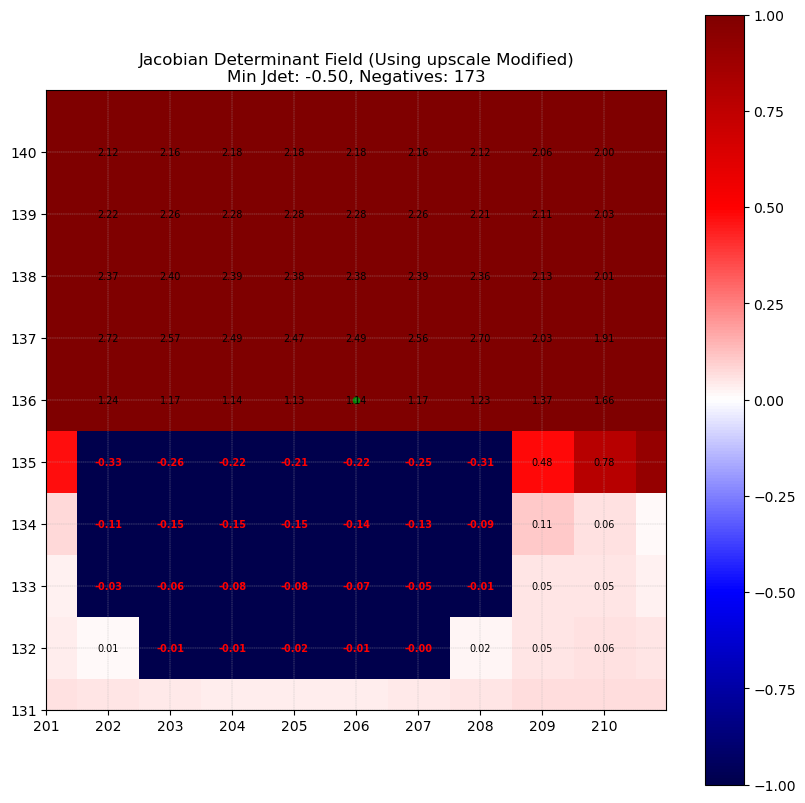

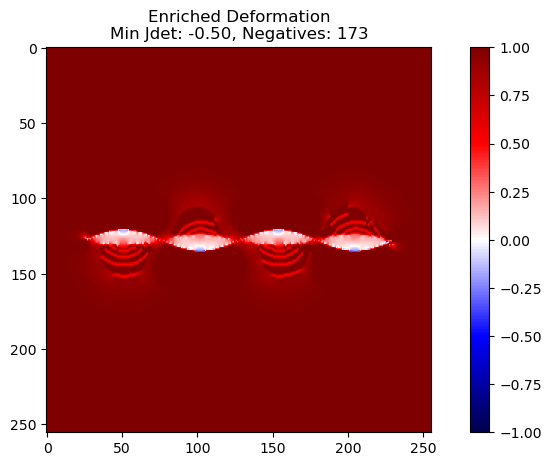

In [57]:
# Assume d_copy is your Data object with original correspondences
# and new_pairs is a list of (moving_coord, fixed_coord) tuples, where each coord is (y, x)

from copy import deepcopy
import numpy as np

# 1. Convert new_pairs to arrays with shape (N, 3) (add z=0 for 2D)
if len(new_pairs) > 0:
    new_mpoints = np.array([[0, y, x] for (y, x), _ in new_pairs])
    new_fpoints = np.array([[0, fy, fx] for _, (fy, fx) in new_pairs])

    # 2. Concatenate with d_copy's existing points
    all_mpoints = np.vstack([d_original.mpoints, new_mpoints])
    all_fpoints = np.vstack([d_original.fpoints, new_fpoints])

    # 3. Create a new Data object with the enriched correspondences
    d_copy = Data(all_mpoints, all_fpoints, d_original.resolution)
    
    
    jacobian_plot(d_copy, pt=correspondence_pt, figsize=(10, 10), title="Jacobian Determinant Field (Using upscale Modified)\nMin Jdet: {:.2f}, Negatives: {}".format(d_copy.min(), d_copy.count_negatives()),
              xlim=(correspondence_pt[1] - 5, correspondence_pt[1] + 5), 
              ylim=(correspondence_pt[0] - 5, correspondence_pt[0] + 5), 
              binarize_negatives=True)
    d_copy.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
                        title=f"Enriched Deformation\nMin Jdet: {d_copy.min():.2f}, Negatives: {d_copy.count_negatives()}")
else:
    print("No new pairs to add.")

# Now d_copy includes the new